#  Time series forecast :  car traffic in parking lot

Author: Yu-Cian Hong

### Business goal:
Forecast daily car traffic to a particular parking lot.

### Data:
Car traffic data of a particular parking lot from 2010 to 2016.

### Instruction for running this code:
Python version: 3.6.1<br>
Jupyter Notebook version: 4.3.0<br>
Required python packages and versions:<br>
matplotlib==3.2.1<br>
numpy==1.18.2<br>
pandas==1.0.3<br>
scikit-learn==0.21.3<br>
scipy==1.4.1<br>
statsmodels==0.12.0.dev0+146.gc0b5d397a

In [1]:
# import python libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.facecolor'] = 'white'
import datetime as dt

from scipy.stats import pearsonr
from scipy.stats import ks_2samp
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.utils import resample
import itertools

# jupyter notebook display settting
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', -1)
from IPython.display import Markdown, display
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"    

# Data summary

In [2]:
# load data
df = pd.read_csv('data.csv')

In [3]:
# initial glimpse of data
df.head(10)

,date,day.of.week,car.count,weather,cloud.indicator
0,2010-01-01,Friday,101,0.1,clear
1,2010-01-02,Saturday,34,0.2,cloudy
2,2010-01-03,Sunday,113,0.4,clear
3,2010-01-04,Monday,5,0.6,cloudy
4,2010-01-05,Tuesday,124,0.1,clear
5,2010-01-06,Wednesday,104,-0.1,clear
6,2010-01-07,Thursday,81,-1.0,clear
7,2010-01-08,Friday,67,-0.3,cloudy
8,2010-01-09,Saturday,89,0.2,cloudy
9,2010-01-10,Sunday,132,1.4,clear


There are time, car count, and weather parameters in 5 data columns.

Inspect data columns:

In [4]:
# data summary
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2373 entries, 0 to 2372
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             2373 non-null   object 
 1   day.of.week      2373 non-null   object 
 2   car.count        2373 non-null   int64  
 3   weather          2373 non-null   float64
 4   cloud.indicator  2373 non-null   object 
dtypes: float64(1), int64(1), object(3)
memory usage: 92.8+ KB


There are 2373 entries with no no missing values in the data.

In [5]:
# Tranform date column to datetime format
df['date']=pd.to_datetime(df['date'])
print ("date range:", df['date'].dt.date.min(),' -> ', df['date'].dt.date.max())

date range: 2010-01-01  ->  2016-06-30


In [6]:
# check if any date is missing
s = df['date'].diff().dt.days.drop(0)!=1
print('Data is continuous in time, with', s[s==True].count(), 'missing dates.')

Data is continuous in time, with 0 missing dates.


Inspect data columns:

In [7]:
# summary statistics of numerical columns
df.describe()

,car.count,weather
count,2373.000000,2373.000000
mean,112.773704,0.008512
std,50.127710,1.007344
min,0.000000,-3.200000
25%,81.000000,-0.700000
50%,122.000000,0.000000
75%,152.000000,0.700000
max,239.000000,4.300000


1. Car counts range from 0 to 240, with average counts 113.

2. Weather values translate to weather conditions. More positive values mean "better weather", and more negative values mean worse weather. Weather ranges from -3.2 to 4.3, with average ~ 0. 

Inspect cloud.indicator:

In [8]:
# inspect values in cloud.indicator
print('fraction of clear and cloudy days:')
df['cloud.indicator'].value_counts(normalize=True)

fraction of clear and cloudy days:


clear     0.570164
cloudy    0.429836
Name: cloud.indicator, dtype: float64

# Exploratory data analysis

### Visualize time series:

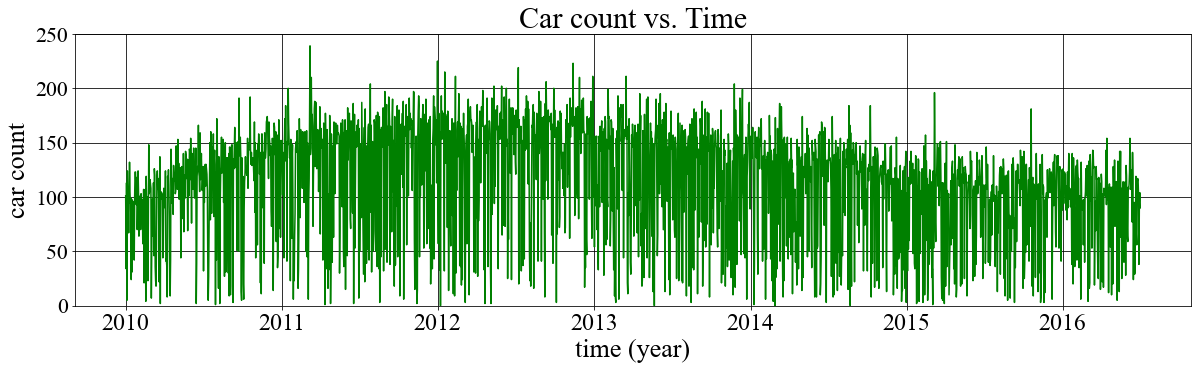

In [9]:
# plot full time series 
f = plt.figure(figsize=(20, 5))
p = plt.plot(df['date'],df['car.count'], linewidth=1.5, color='green')
t = plt.title('Car count vs. Time', fontname="Times New Roman", fontsize=30)
x = plt.xlabel('time (year)', fontname="Times New Roman", fontsize=26)
y =  plt.ylabel('car count', fontname="Times New Roman", fontsize=26)
xi = plt.xticks(fontname="Times New Roman", fontsize=24)  
yi = plt.yticks(fontname="Times New Roman", fontsize=22) 
yl = plt.ylim(0, 250)
plt.grid(color='black')

plt.show()

#### Comments:

1. The time series seems to have some seasonality and trend on the top part, but is very noisy.<br>
2. Cloudy days probably impose limitations on car visiblity, so let's plot clear and cloudy days separately.

### Separate clear and cloudy days:

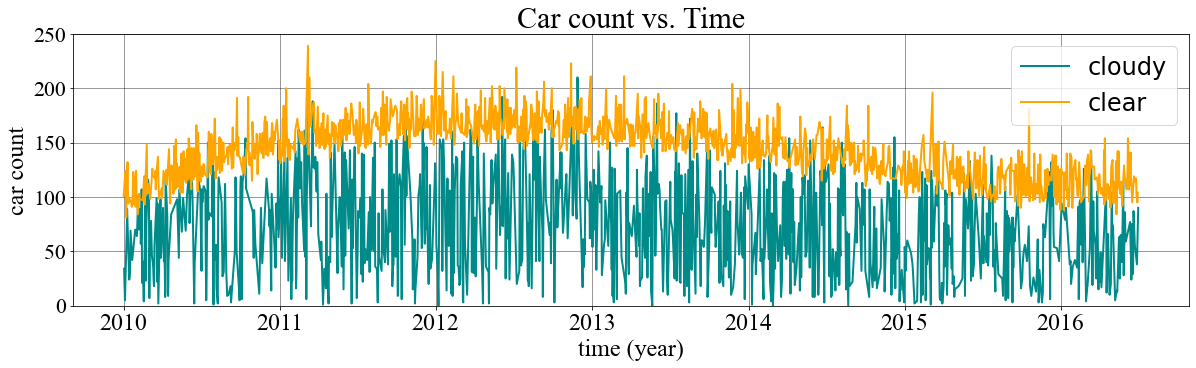

In [10]:
# split data into cloudy and clear days
cloudy = df[df['cloud.indicator']=='cloudy'].reset_index().drop('index', axis=1)
clear = df[df['cloud.indicator']=='clear'].reset_index().drop('index', axis=1)

# plot time series for cloudy and clear days separately
f = plt.figure(figsize=(20, 5))
p1 = plt.plot(cloudy['date'], cloudy['car.count'], linewidth=2, color='darkcyan', label='cloudy')
p2 = plt.plot(clear['date'], clear['car.count'], linewidth=2, color='orange', label='clear')
t = plt.title('Car count vs. Time', fontname="Times New Roman", fontsize=30)
x = plt.xlabel('time (year)', fontname="Times New Roman", fontsize=24)
y = plt.ylabel('car count', fontname="Times New Roman", fontsize=24)
xi = plt.xticks(fontname="Times New Roman", fontsize=24)  
yi = plt.yticks(fontname="Times New Roman", fontsize=22) 
xl = plt.ylim(0, 250)
l = plt.legend(fontsize=24)
plt.grid(color='black', alpha=0.5)


plt.show()

#### Comments:

1. Clear days have pretty consistently higher car counts than cloudy days, probably because cloudy days inevitably limit car visibility. It may not mean cusomer behavior changes with cloud coverage.<br><br>
2. Clear days show a clear trend and some seasonality. It is much less noisy than the full time series.
   Besides, there are often high peaks near March and October, so including holiday effects in the forecast can be valuable.<br><br>
3. Cloudy days have less car counts and are much more noisy due to varations in cloud coverage. The data don't show the true car counts, and there is no information on cloud coverage to help retrieve car counts. For the purpose of modeling, special treatment is needed for the cloudy part of data.<br><br>
4. The shape of the time series for clear days somewhat match cloudy days. There are probably some correlations, which we will investigate further. 

#### Statistics of car counts for clear and cloudy days:

In [11]:
# summary statistics for cloudy and clear days
print('car counts for cloudy days:')
cloudy['car.count'].describe().to_frame()
print('\ncar counts for clear days:')
clear['car.count'].describe().to_frame()

car counts for cloudy days:


,car.count
count,1020.000000
mean,71.602941
std,44.428109
min,0.000000
25%,34.000000
50%,69.000000
75%,106.000000
max,210.000000



car counts for clear days:


,car.count
count,1353.000000
mean,143.811530
std,26.038077
min,81.000000
25%,124.000000
50%,146.000000
75%,162.000000
max,239.000000


#### Comments:
1. Clear days have higher average car counts, and cloudy days have higher standard variation. These are expected as clouds decrease visibility of cars, and the lack of information on cloud coverage contributes to the large variance of car counts.<br><br>
2. Average car counts for clear days are twice of the cloudy day average.<br><br>
3. The standard variation for cloudy days are nearly twice that of the clear days.

Since the shape of the time series for clear and cloudy days look somewhat similar, we will check their correlation. Because now clear and cloudy day data are separated, the missing values in each are interpolated.

In [12]:
# fill missing values

# reindex by date
clear.index = clear.date
cloudy.index = cloudy.date

# forward fill for missing values
clear1 = clear['car.count']
clear1 = clear1.resample('D').ffill()

cloudy1 = cloudy['car.count']
cloudy1 = cloudy1.resample('D').ffill()

In [13]:
# correlation between clear and cloudy days
cc = pearsonr(clear1, cloudy1)
print('correlation between clear and cloudy day data:\n')
print ('correlation coefficient:%4.2f' % cc[0])
print ('p-value:%6.4f' % cc[1])

correlation between clear and cloudy day data:

correlation coefficient:0.25
p-value:0.0000


#### Comment:
There is a statistically significant but weak positive correlation between clear and cloudy day data.

The visualization below better captures their correlation. The data for cloudy days are rescaled to match the average car counts for clear days.

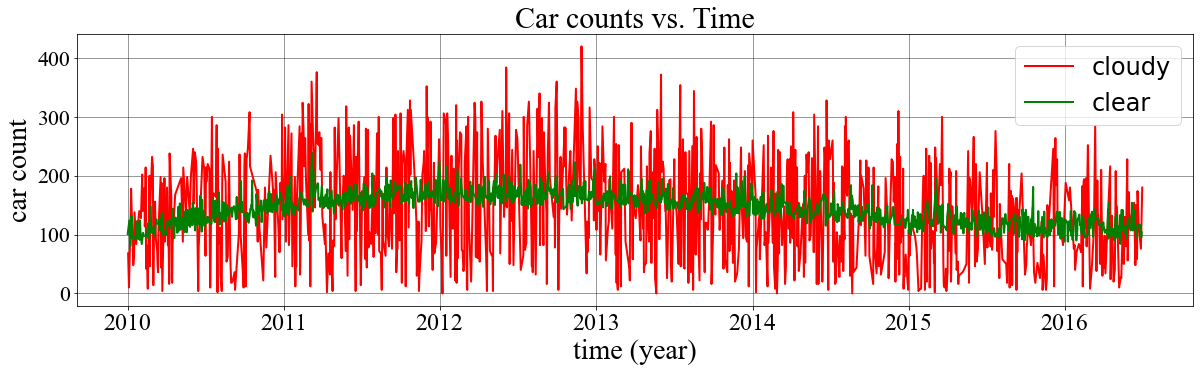

In [14]:
# multiply cloudy day car counts by 2
f1 = lambda x: x * 2
cloudy['rescale'] = cloudy['car.count'].apply(f1)

# plot rescaled time series
f = plt.figure(figsize=(20, 5))
p1 = plt.plot(cloudy['date'], cloudy['rescale'], linewidth=2, color='red', label='cloudy')
p2 = plt.plot(clear['date'], clear['car.count'], linewidth=2, color='green', label='clear')
t = plt.title('Car counts vs. Time', fontname="Times New Roman", fontsize=30)
x = plt.xlabel('time (year)', fontname="Times New Roman", fontsize=28)
y = plt.ylabel('car count', fontname="Times New Roman", fontsize=28)
xi = plt.xticks(fontname="Times New Roman", fontsize=24)  
yi = plt.yticks(fontname="Times New Roman", fontsize=22) 
l = plt.legend(fontsize=24)
plt.grid(color='black', alpha=0.5)

plt.show()

#### Comment:
1. Weak positive correlations exist between clear and cloudy day data.<br><br>
2. Their time series look qualitatively similar (ie. trend,seasonality), except for the large noise on cloudy days.<br><br>
3. These observations show that cloudy day data are valuable, although its much larger variance has to be taken into account in modeling.

### Data correlations

We will look into data correlations, especially to see if weather can be valuable information in predicting car counts.

In [15]:
# translate cloud.indicator to number
df.loc[df['cloud.indicator']=='cloudy', 'cloud.indicator'] = 1.
df.loc[df['cloud.indicator']=='clear', 'cloud.indicator'] = 0.
df['cloud.indicator'] = df['cloud.indicator'].astype(float)

# correlations between data columns
df.corr(method='pearson')

,car.count,weather,cloud.indicator
car.count,1.00000,0.007040,-0.713270
weather,0.00704,1.000000,-0.008437
cloud.indicator,-0.71327,-0.008437,1.000000


#### Comment:
1. Weather doesn't have any significant correlations with car counts or cloud coverage. It may contribute little in car counts forecasting based on this analysis.<br><br>
2. There's a high correlation between car counts and cloud indicator, which agrees with previous analysis.

Since car counts on clear days are more reliable, let's try to explore correlations on clear and cloudy days separately:

In [1]:
# correlation between car counts and weather

# clear days
print('clear days:')
clear.corr()

# cloudy days
print('\ncloudy days:')
cloudy.drop('rescale', axis=1).corr()

clear days:


NameError: name 'clear' is not defined

K-S test on weather for clear and cloudy days:

In [17]:
# K-S test on weather distribution between clear and cloudy days
ks_2samp(clear['weather'], cloudy['weather'])

Ks_2sampResult(statistic=0.037424459806095385, pvalue=0.37722173736016384)

Weather still has no significant correlations with car counts, and K-S test can't reject the null hypothesis that car counts from clear and cloudy days are from the same distribution. Therefore, weather will not be considered in modeling. 

To add, the lack of correlation between car counts and weather may help strengthen the argument that customer bahevior may not change based on cloud coverage, since predumably weather conditions pose more restriction on human movement than cloud coverage. 

### Seasonality
Let's look at the time series close-up to see if there's any seasonality.

In [18]:
# plot individual months
from matplotlib.dates import DateFormatter
import matplotlib.ticker as ticker

# function to plot month
def plot_month(series, yr, mn, title):
    f, ax = plt.subplots(figsize=(20, 5))
    xx1 = ax.xaxis.set_major_formatter(DateFormatter('%u'))
    xx2 = ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    
    p = plt.plot(series[(series.index.year==yr) & (series.index.month==mn)].index,
                 series[(series.index.year==yr) & (series.index.month==mn)], '-p', linewidth=2, color='darkcyan')
    
    t = plt.title(title + ' days in ' + str(yr) + '.' + str(mn), fontname="Times New Roman", fontsize=28)
    x = plt.xlabel('time (day of week)', fontname="Times New Roman", fontsize=24)
    y = plt.ylabel('car count',fontname="Times New Roman", fontsize=24)
    xi = plt.xticks(fontname="Times New Roman", fontsize=24)  
    yi = plt.yticks(fontname="Times New Roman", fontsize=22) 
    plt.grid(color='black', alpha=0.2)
    plt.show()  

<br><br>Inspect some months: 
#### (1-7: Monday-Sunday)

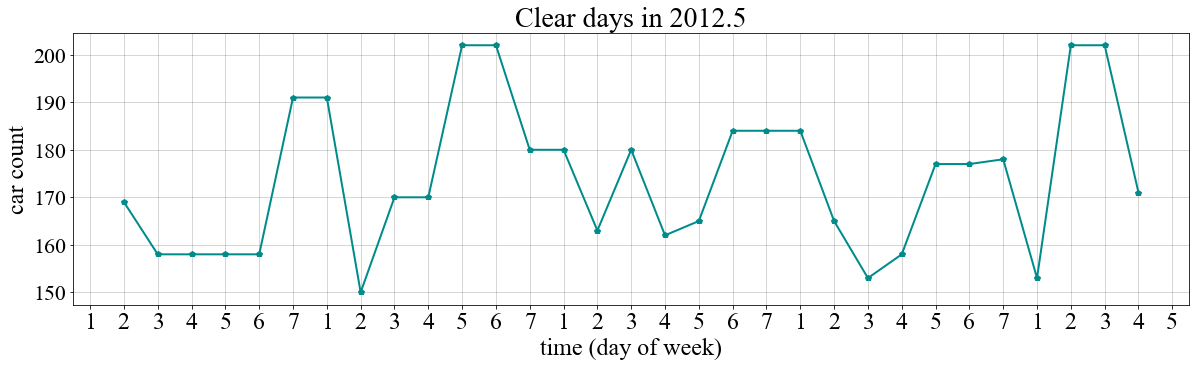

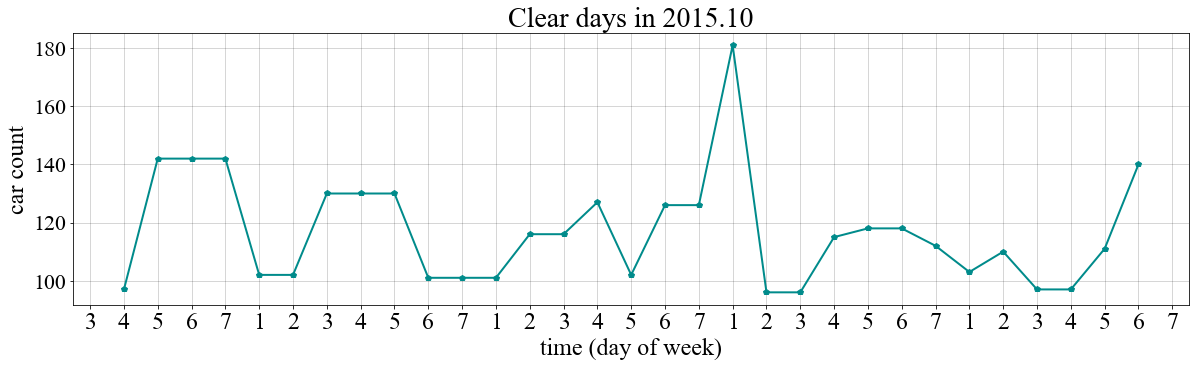

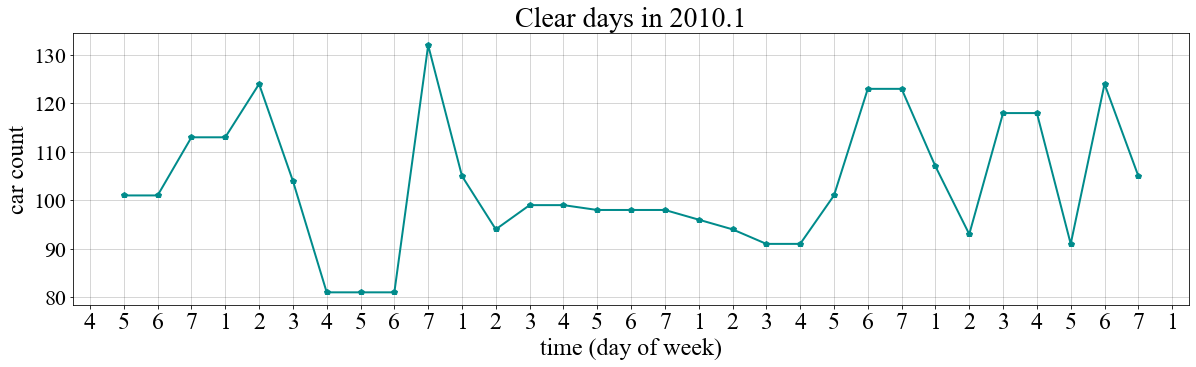

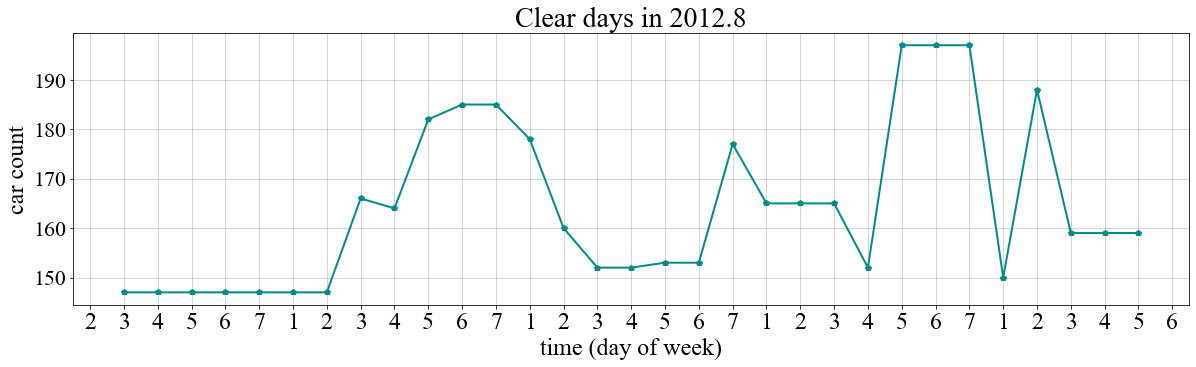

In [19]:
# plot some different months
plot_month(clear1, 2012, 5, 'Clear')
plot_month(clear1, 2015, 10, 'Clear')
plot_month(clear1, 2010, 1, 'Clear')
plot_month(clear1, 2012, 8, 'Clear')

plt.show()

#### Comment:
$*$ Note that missing values are replaced by forward fill.<br>
There are weekly trends in most months. Roughly every week, car counts complete a full upper sinusoial shape. Among the inspected months, the peaks occur more often on the weekend, or one of the weekend days. Some months have valleys near Tuesday, but some closer to Thursday.

<br><br><br>
#### Clear days in 2010, 2012, 2014
The time series for clear days show weeklish to bi-weeklish seasonality, plus some trend and noise. There also seems to be temporal monthly to bi-monthly seasonality. The weekly trend is more consistent throughout the time series, so weekly seasonality will be chosen for the following forecasting model, which utilizes the full data.

In [20]:
# function to plot year
def plot_year(series, yr, title):
    f = plt.figure(figsize=(20, 5))
    p = plt.plot(series[series.index.year==yr].index, series[series.index.year==yr], linewidth=2, color='darkcyan')
    t = plt.title(title + ' days in ' + str(yr), fontname="Times New Roman", fontsize=28)
    x = plt.xlabel('time (year-month)', fontname="Times New Roman", fontsize=24)
    y = plt.ylabel('car count', fontname="Times New Roman", fontsize=24)
    xi = plt.xticks(fontname="Times New Roman", fontsize=24)  
    yi = plt.yticks(fontname="Times New Roman", fontsize=22) 
    plt.grid(color='black', alpha=0.2)
    plt.show()

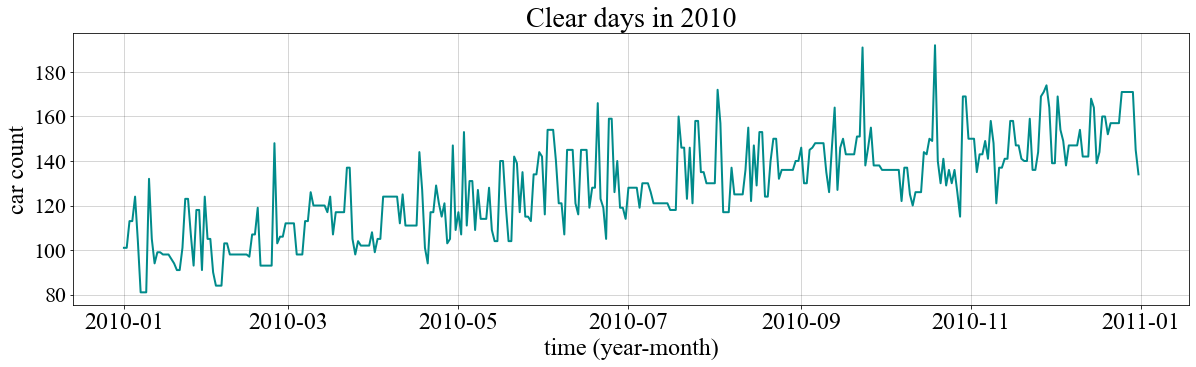

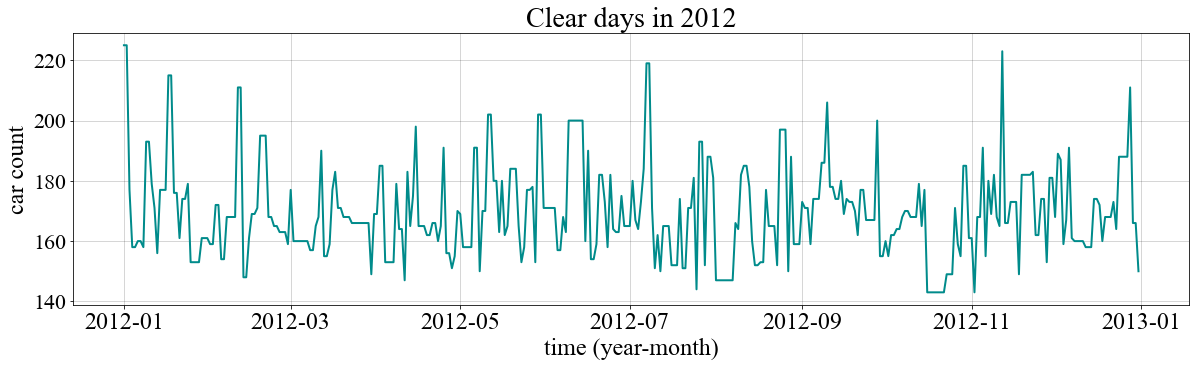

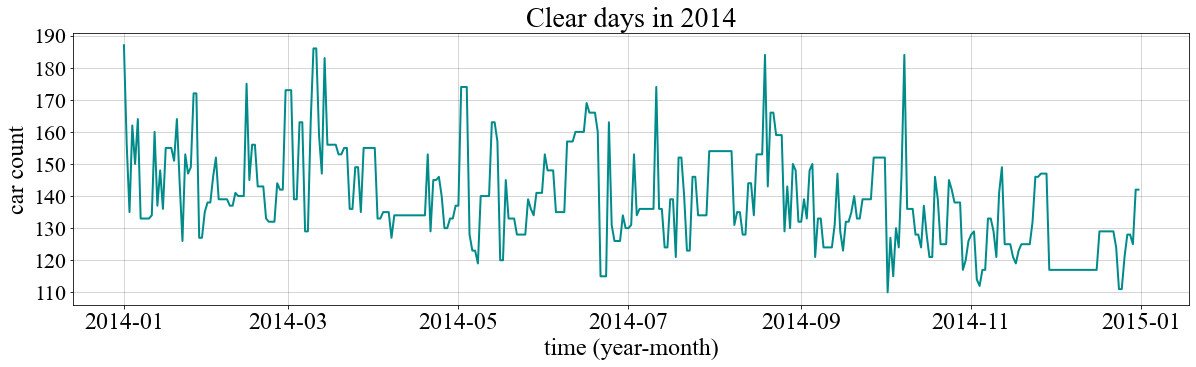

In [21]:
# plot clear days for certain years
for yr in range(2010, 2016, 2):
    p = plot_year(clear1, yr, 'Clear')
    plt.show()

<br><br><br>
#### Cloudy days in 2010, 2012, 2014:
Like clear day data, the time series for cloudy days also show weeklish to bi-weeklish seasonality, as well as monthlish seasonality. For modeling purposes, the most consistent weekly seasonality will also be used.

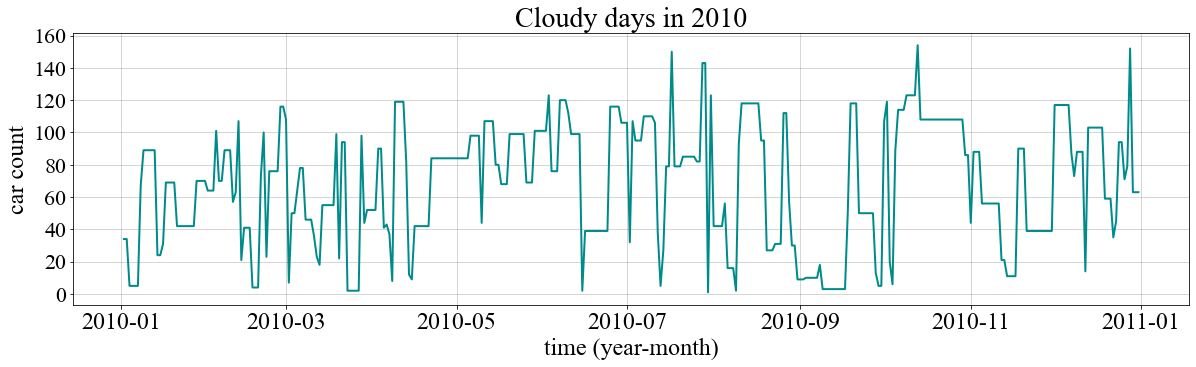

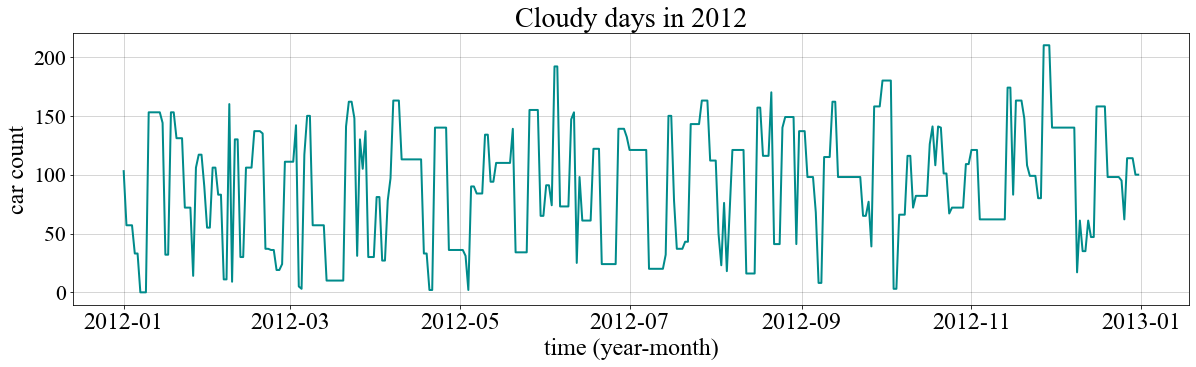

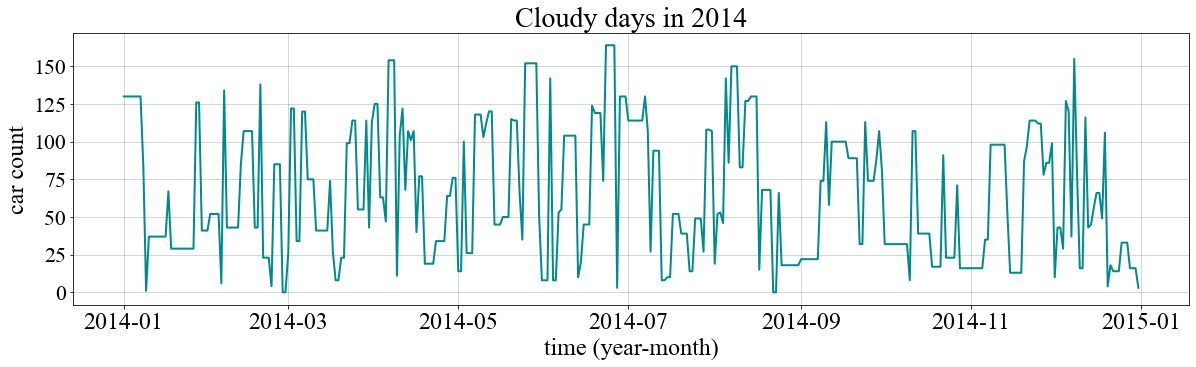

In [22]:
# plot cloudy days for certain years
for yr in range(2010, 2016, 2):
    p = plot_year(cloudy1, yr, 'Cloudy')
    plt.show()

### Summary of EDA

1. Car counts on clear days are twice higher than cloudy days, probably mostly because cloud blocks cars from view.
<br><br>
2. Cloudy days have a larger variance on car counts, probably contributed by the lack of detailed information on cloud coverage.
<br><br>
3. Cloudy day car counts may be quite valuable. Despite of its large variance due to varying cloud coverage, it appears qualitatively similar to clear day car counts. Cloudy day car counts can be used to build a separate model. This helps the clear day data retain its lower variance in its forecast. Alternatively, if assuming customer behavior can't be changed by cloud coverage, the model can build on clear days only, and cloudy day data can be removed from modeling. Of course it will be best to if a more precise cloud coverage is known, so that cloudy day car counts can be interpolated.
<br><br>
4. Weather doesn't correlate with car counts and cloud coverage. 
<br><br>
5. Both the clear and cloudy day car counts show weekly seasonality, so SARIMA will be used for modeling.

### Modeling approach
1. Build separate time series forceasting model for clear and cloudy days.
<br><br>
2. Use SARIMA with weely seasonality for both clear and cloudy days.

# Modeling

First of all we want to check if the data is still evenly sampled in time after cloudy days are separated out. The clear day data is evenly distributed in month. It consists of about 60% of the original data. The missing part of data will be replaced by forward fill.

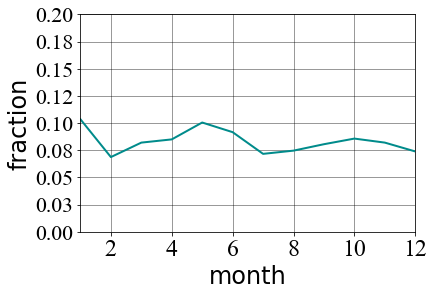

In [23]:
# plot number of data points each month for clear days
import matplotlib.ticker as mtick

x = clear['date'].dt.month.value_counts(normalize=True).sort_index()
p = x.plot(linewidth=2, color='darkcyan')
x = plt.xlabel('month', fontsize=24)
y = plt.ylabel('fraction', fontsize=24)
xi = plt.xticks(fontname="Times New Roman", fontsize=24)  
yi = plt.yticks(fontname="Times New Roman", fontsize=22) 
xl = plt.xlim(1, 12)
yl = plt.ylim(0, 0.2)
p.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))

l = plt.legend(fontsize=24)
l.remove()
plt.grid(color='black', alpha=0.5)

plt.show()

## Model training
To build a model to forecast car counts 1 day in advance, we train the model on the time series. The last 5 months of data is separated out as the test set, in order to test the model's out of sample performance and check on overfitting. The rest of the data is used for training. Two separate models are trained for clear and cloudy days.

### 1.  Clear days

In [24]:
# split out training set
test_len = 150
train_len = clear1.shape[0] - test_len
train1 = clear1[:train_len]

####  SARIMA model

The model is tuned using grid search. A combination of AIC score, statistical significance of the fitted coefficients, model complexity, and diagnosis of residual is used to select the best model. Choosing AIC score over RMSE can help guard against overfitting.

In [25]:
# find the best SARIMA model with grid search (5 min run)

# set parameter range
p = range(0, 3)
d = range(1, 3)
q = range(1, 3)
P = range(0, 2)
D = range(0, 2)
Q = range(0, 2)
s = range(7, 8)

# create all parameter combinations
pdq = list(itertools.product(p, d, q))
pdq_season = list(itertools.product(P, D, Q, s))

# SARIMA
for param in pdq:
    for param_s in pdq_season:
            mod = SARIMAX(train1,
                          order=param,
                          seasonal_order=param_s)
            res = mod.fit()
            print('SARIMA{},{} - AIC:{}'.format(param, param_s, res.aic))
            res.summary().tables[1]

SARIMA(0, 1, 1),(0, 0, 0, 7) - AIC:18086.89859595988


,coef,std err,z,P>|z|,[0.025,0.975]
ma.L1,-0.7208,0.012,-57.876,0.000,-0.745,-0.696
sigma2,201.0545,4.216,47.690,0.000,192.792,209.317


SARIMA(0, 1, 1),(0, 0, 1, 7) - AIC:18082.039704042538


,coef,std err,z,P>|z|,[0.025,0.975]
ma.L1,-0.7429,0.012,-60.822,0.000,-0.767,-0.719
ma.S.L7,-0.0563,0.022,-2.526,0.012,-0.100,-0.013
sigma2,200.4200,4.253,47.130,0.000,192.085,208.755


SARIMA(0, 1, 1),(0, 1, 0, 7) - AIC:19635.616713271564


,coef,std err,z,P>|z|,[0.025,0.975]
ma.L1,-0.5372,0.015,-34.900,0.000,-0.567,-0.507
sigma2,415.2897,10.385,39.989,0.000,394.935,435.644


SARIMA(0, 1, 1),(0, 1, 1, 7) - AIC:18040.703156689095


,coef,std err,z,P>|z|,[0.025,0.975]
ma.L1,-0.7135,0.013,-54.853,0.000,-0.739,-0.688
ma.S.L7,-0.9995,0.072,-13.826,0.000,-1.141,-0.858
sigma2,198.2654,15.304,12.955,0.000,168.271,228.260


SARIMA(0, 1, 1),(1, 0, 0, 7) - AIC:18081.687460183493


,coef,std err,z,P>|z|,[0.025,0.975]
ma.L1,-0.7431,0.012,-60.898,0.000,-0.767,-0.719
ar.S.L7,-0.0590,0.022,-2.629,0.009,-0.103,-0.015
sigma2,200.3910,4.251,47.137,0.000,192.059,208.723


SARIMA(0, 1, 1),(1, 0, 1, 7) - AIC:18083.035955593703


,coef,std err,z,P>|z|,[0.025,0.975]
ma.L1,-0.7394,0.012,-60.219,0.000,-0.763,-0.715
ar.S.L7,-0.3054,0.317,-0.965,0.335,-0.926,0.315
ma.S.L7,0.2473,0.321,0.771,0.441,-0.381,0.876
sigma2,200.3341,4.241,47.238,0.000,192.022,208.646


SARIMA(0, 1, 1),(1, 1, 0, 7) - AIC:18907.281710133946


,coef,std err,z,P>|z|,[0.025,0.975]
ma.L1,-0.6203,0.015,-41.376,0.000,-0.650,-0.591
ar.S.L7,-0.5343,0.016,-33.503,0.000,-0.566,-0.503
sigma2,298.2599,7.068,42.199,0.000,284.407,312.113


SARIMA(0, 1, 1),(1, 1, 1, 7) - AIC:18031.417416419637


,coef,std err,z,P>|z|,[0.025,0.975]
ma.L1,-0.7392,0.013,-58.040,0.000,-0.764,-0.714
ar.S.L7,-0.0738,0.023,-3.212,0.001,-0.119,-0.029
ma.S.L7,-0.9997,0.103,-9.681,0.000,-1.202,-0.797
sigma2,197.1432,21.148,9.322,0.000,155.693,238.593


SARIMA(0, 1, 2),(0, 0, 0, 7) - AIC:17880.683499889066


,coef,std err,z,P>|z|,[0.025,0.975]
ma.L1,-0.6039,0.016,-36.901,0.000,-0.636,-0.572
ma.L2,-0.3071,0.017,-17.736,0.000,-0.341,-0.273
sigma2,182.9852,3.928,46.581,0.000,175.286,190.685


SARIMA(0, 1, 2),(0, 0, 1, 7) - AIC:17881.981690039203


,coef,std err,z,P>|z|,[0.025,0.975]
ma.L1,-0.6030,0.016,-36.825,0.000,-0.635,-0.571
ma.L2,-0.3043,0.018,-17.344,0.000,-0.339,-0.270
ma.S.L7,-0.0183,0.023,-0.805,0.421,-0.063,0.026
sigma2,182.9210,3.932,46.517,0.000,175.214,190.628


SARIMA(0, 1, 2),(0, 1, 0, 7) - AIC:19290.856868645697


,coef,std err,z,P>|z|,[0.025,0.975]
ma.L1,-0.6510,0.036,-17.865,0.000,-0.722,-0.580
ma.L2,-0.3489,0.021,-16.568,0.000,-0.390,-0.308
sigma2,353.9890,14.458,24.484,0.000,325.652,382.326


SARIMA(0, 1, 2),(0, 1, 1, 7) - AIC:17850.308058248927


,coef,std err,z,P>|z|,[0.025,0.975]
ma.L1,-0.6071,0.017,-35.653,0.000,-0.640,-0.574
ma.L2,-0.2994,0.017,-17.367,0.000,-0.333,-0.266
ma.S.L7,-0.9995,0.051,-19.683,0.000,-1.099,-0.900
sigma2,181.5763,10.746,16.897,0.000,160.514,202.638


SARIMA(0, 1, 2),(1, 0, 0, 7) - AIC:17881.955676677306


,coef,std err,z,P>|z|,[0.025,0.975]
ma.L1,-0.6031,0.016,-36.824,0.000,-0.635,-0.571
ma.L2,-0.3042,0.018,-17.344,0.000,-0.339,-0.270
ar.S.L7,-0.0190,0.023,-0.833,0.405,-0.064,0.026
sigma2,182.9290,3.933,46.513,0.000,175.221,190.637


SARIMA(0, 1, 2),(1, 0, 1, 7) - AIC:17883.46818401658


,coef,std err,z,P>|z|,[0.025,0.975]
ma.L1,-0.6030,0.016,-36.805,0.000,-0.635,-0.571
ma.L2,-0.3048,0.017,-17.459,0.000,-0.339,-0.271
ar.S.L7,-0.5703,0.608,-0.938,0.348,-1.762,0.621
ma.S.L7,0.5507,0.619,0.890,0.373,-0.662,1.763
sigma2,182.8598,3.937,46.441,0.000,175.142,190.577


SARIMA(0, 1, 2),(1, 1, 0, 7) - AIC:18631.493870593476


,coef,std err,z,P>|z|,[0.025,0.975]
ma.L1,-0.6455,0.018,-36.169,0.000,-0.681,-0.611
ma.L2,-0.3536,0.017,-20.251,0.000,-0.388,-0.319
ar.S.L7,-0.5093,0.017,-30.432,0.000,-0.542,-0.476
sigma2,262.3686,6.610,39.695,0.000,249.414,275.323


SARIMA(0, 1, 2),(1, 1, 1, 7) - AIC:17850.381405658372


,coef,std err,z,P>|z|,[0.025,0.975]
ma.L1,-0.6062,0.017,-35.586,0.000,-0.640,-0.573
ma.L2,-0.2940,0.017,-16.817,0.000,-0.328,-0.260
ar.S.L7,-0.0310,0.023,-1.325,0.185,-0.077,0.015
ma.S.L7,-0.9998,0.129,-7.728,0.000,-1.253,-0.746
sigma2,181.3406,24.475,7.409,0.000,133.371,229.310


SARIMA(0, 2, 1),(0, 0, 0, 7) - AIC:18549.11931909489


,coef,std err,z,P>|z|,[0.025,0.975]
ma.L1,-0.9998,0.045,-22.355,0.000,-1.087,-0.912
sigma2,247.7646,11.682,21.209,0.000,224.868,270.661


SARIMA(0, 2, 1),(0, 0, 1, 7) - AIC:18551.052698135187


,coef,std err,z,P>|z|,[0.025,0.975]
ma.L1,-0.9999,0.150,-6.665,0.000,-1.294,-0.706
ma.S.L7,0.0037,0.023,0.163,0.871,-0.040,0.048
sigma2,247.7293,37.196,6.660,0.000,174.827,320.632


SARIMA(0, 2, 1),(0, 1, 0, 7) - AIC:20016.822667255525


,coef,std err,z,P>|z|,[0.025,0.975]
ma.L1,-0.9995,0.052,-19.293,0.000,-1.101,-0.898
sigma2,493.9311,28.339,17.430,0.000,438.388,549.474


SARIMA(0, 2, 1),(0, 1, 1, 7) - AIC:18528.59167146094


,coef,std err,z,P>|z|,[0.025,0.975]
ma.L1,-0.9995,0.080,-12.488,0.000,-1.156,-0.843
ma.S.L7,-0.9979,0.016,-60.873,0.000,-1.030,-0.966
sigma2,247.0329,21.051,11.735,0.000,205.774,288.292


SARIMA(0, 2, 1),(1, 0, 0, 7) - AIC:18551.10046908641


,coef,std err,z,P>|z|,[0.025,0.975]
ma.L1,-0.9997,0.038,-26.020,0.000,-1.075,-0.924
ar.S.L7,0.0039,0.023,0.175,0.861,-0.040,0.048
sigma2,247.7667,10.250,24.173,0.000,227.678,267.856


SARIMA(0, 2, 1),(1, 0, 1, 7) - AIC:18549.74933091012


,coef,std err,z,P>|z|,[0.025,0.975]
ma.L1,-1.0000,0.225,-4.438,0.000,-1.442,-0.558
ar.S.L7,0.9411,0.068,13.789,0.000,0.807,1.075
ma.S.L7,-0.9277,0.076,-12.253,0.000,-1.076,-0.779
sigma2,247.4259,55.685,4.443,0.000,138.285,356.567


SARIMA(0, 2, 1),(1, 1, 0, 7) - AIC:19332.443664387545


,coef,std err,z,P>|z|,[0.025,0.975]
ma.L1,-0.9999,0.323,-3.095,0.002,-1.633,-0.367
ar.S.L7,-0.5172,0.015,-35.230,0.000,-0.546,-0.488
sigma2,361.5819,117.048,3.089,0.002,132.172,590.992


SARIMA(0, 2, 1),(1, 1, 1, 7) - AIC:18530.67227493073


,coef,std err,z,P>|z|,[0.025,0.975]
ma.L1,-0.9993,0.065,-15.259,0.000,-1.128,-0.871
ar.S.L7,-0.0029,0.023,-0.128,0.898,-0.048,0.042
ma.S.L7,-0.9977,0.015,-66.942,0.000,-1.027,-0.968
sigma2,247.0378,17.544,14.081,0.000,212.652,281.424


SARIMA(0, 2, 2),(0, 0, 0, 7) - AIC:18092.007025559826


,coef,std err,z,P>|z|,[0.025,0.975]
ma.L1,-1.7170,0.022,-77.159,0.000,-1.761,-1.673
ma.L2,0.7170,0.018,39.184,0.000,0.681,0.753
sigma2,201.1724,6.062,33.183,0.000,189.290,213.055


SARIMA(0, 2, 2),(0, 0, 1, 7) - AIC:18087.4240636456


,coef,std err,z,P>|z|,[0.025,0.975]
ma.L1,-1.7390,0.023,-77.009,0.000,-1.783,-1.695
ma.L2,0.7391,0.019,39.386,0.000,0.702,0.776
ma.S.L7,-0.0552,0.022,-2.472,0.013,-0.099,-0.011
sigma2,200.5448,6.168,32.512,0.000,188.455,212.634


SARIMA(0, 2, 2),(0, 1, 0, 7) - AIC:19638.988268155816


,coef,std err,z,P>|z|,[0.025,0.975]
ma.L1,-1.5357,0.354,-4.338,0.000,-2.230,-0.842
ma.L2,0.5357,0.186,2.887,0.004,0.172,0.899
sigma2,415.5442,150.831,2.755,0.006,119.920,711.168


SARIMA(0, 2, 2),(0, 1, 1, 7) - AIC:18057.123050254573


,coef,std err,z,P>|z|,[0.025,0.975]
ma.L1,-1.7014,0.014,-124.142,0.000,-1.728,-1.675
ma.L2,0.7024,0.013,54.017,0.000,0.677,0.728
ma.S.L7,-0.9984,0.023,-43.338,0.000,-1.044,-0.953
sigma2,199.2787,6.601,30.187,0.000,186.340,212.217


SARIMA(0, 2, 2),(1, 0, 0, 7) - AIC:18087.0691972809


,coef,std err,z,P>|z|,[0.025,0.975]
ma.L1,-1.7393,0.029,-59.448,0.000,-1.797,-1.682
ma.L2,0.7393,0.023,31.745,0.000,0.694,0.785
ar.S.L7,-0.0580,0.023,-2.576,0.010,-0.102,-0.014
sigma2,200.4700,7.342,27.304,0.000,186.079,214.860


SARIMA(0, 2, 2),(1, 0, 1, 7) - AIC:18088.369515973474


,coef,std err,z,P>|z|,[0.025,0.975]
ma.L1,-1.7354,0.023,-75.767,0.000,-1.780,-1.691
ma.L2,0.7354,0.019,38.817,0.000,0.698,0.773
ar.S.L7,-0.3148,0.320,-0.984,0.325,-0.942,0.312
ma.S.L7,0.2578,0.324,0.795,0.427,-0.378,0.894
sigma2,200.4083,6.197,32.342,0.000,188.263,212.553


SARIMA(0, 2, 2),(1, 1, 0, 7) - AIC:18912.231578189727


,coef,std err,z,P>|z|,[0.025,0.975]
ma.L1,-1.6183,0.340,-4.758,0.000,-2.285,-0.952
ma.L2,0.6183,0.207,2.987,0.003,0.213,1.024
ar.S.L7,-0.5339,0.016,-33.284,0.000,-0.565,-0.502
sigma2,298.4333,104.387,2.859,0.004,93.838,503.029


SARIMA(0, 2, 2),(1, 1, 1, 7) - AIC:18047.653965390786


,coef,std err,z,P>|z|,[0.025,0.975]
ma.L1,-1.7294,0.013,-131.818,0.000,-1.755,-1.704
ma.L2,0.7302,0.013,57.689,0.000,0.705,0.755
ar.S.L7,-0.0725,0.023,-3.125,0.002,-0.118,-0.027
ma.S.L7,-0.9991,0.039,-25.406,0.000,-1.076,-0.922
sigma2,198.0927,9.083,21.809,0.000,180.291,215.895


SARIMA(1, 1, 1),(0, 0, 0, 7) - AIC:17837.01069402412


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.3929,0.017,22.731,0.000,0.359,0.427
ma.L1,-0.9597,0.007,-141.772,0.000,-0.973,-0.946
sigma2,179.4106,3.752,47.820,0.000,172.057,186.764


SARIMA(1, 1, 1),(0, 0, 1, 7) - AIC:17838.98099186078


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.3933,0.017,22.552,0.000,0.359,0.427
ma.L1,-0.9599,0.007,-138.822,0.000,-0.973,-0.946
ma.S.L7,0.0037,0.023,0.161,0.872,-0.041,0.049
sigma2,179.4166,3.758,47.748,0.000,172.052,186.781


SARIMA(1, 1, 1),(0, 1, 0, 7) - AIC:19234.49233678118


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.3991,0.016,24.260,0.000,0.367,0.431
ma.L1,-0.9998,0.016,-63.664,0.000,-1.031,-0.969
sigma2,345.2049,10.029,34.421,0.000,325.549,364.861


SARIMA(1, 1, 1),(0, 1, 1, 7) - AIC:17805.971631537534


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.3924,0.017,22.444,0.000,0.358,0.427
ma.L1,-0.9642,0.007,-139.264,0.000,-0.978,-0.951
ma.S.L7,-0.9902,0.005,-203.624,0.000,-1.000,-0.981
sigma2,178.8196,4.389,40.742,0.000,170.217,187.422


SARIMA(1, 1, 1),(1, 0, 0, 7) - AIC:17838.978965341463


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.3933,0.017,22.553,0.000,0.359,0.427
ma.L1,-0.9599,0.007,-138.854,0.000,-0.973,-0.946
ar.S.L7,0.0039,0.023,0.171,0.864,-0.041,0.049
sigma2,179.4107,3.757,47.751,0.000,172.047,186.775


SARIMA(1, 1, 1),(1, 0, 1, 7) - AIC:17830.277783094934


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.3939,0.018,22.051,0.000,0.359,0.429
ma.L1,-0.9642,0.007,-144.732,0.000,-0.977,-0.951
ar.S.L7,0.9958,0.005,188.668,0.000,0.985,1.006
ma.S.L7,-0.9886,0.009,-107.884,0.000,-1.007,-0.971
sigma2,178.4083,4.074,43.789,0.000,170.423,186.394


SARIMA(1, 1, 1),(1, 1, 0, 7) - AIC:18565.84098200003


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.4093,0.017,24.235,0.000,0.376,0.442
ma.L1,-0.9999,0.028,-35.428,0.000,-1.055,-0.945
ar.S.L7,-0.5122,0.016,-31.552,0.000,-0.544,-0.480
sigma2,254.6131,9.908,25.698,0.000,235.194,274.033


SARIMA(1, 1, 1),(1, 1, 1, 7) - AIC:17807.8887056084


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.3918,0.018,22.272,0.000,0.357,0.426
ma.L1,-0.9637,0.007,-135.191,0.000,-0.978,-0.950
ar.S.L7,-0.0063,0.023,-0.272,0.786,-0.052,0.039
ma.S.L7,-0.9901,0.005,-203.171,0.000,-1.000,-0.981
sigma2,178.8123,4.388,40.748,0.000,170.212,187.413


SARIMA(1, 1, 2),(0, 0, 0, 7) - AIC:17838.733449057203


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.4190,0.052,8.074,0.000,0.317,0.521
ma.L1,-0.9899,0.056,-17.731,0.000,-1.099,-0.880
ma.L2,0.0281,0.051,0.546,0.585,-0.073,0.129
sigma2,179.3949,3.757,47.749,0.000,172.031,186.759


SARIMA(1, 1, 2),(0, 0, 1, 7) - AIC:17840.692309598606


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.4199,0.052,8.061,0.000,0.318,0.522
ma.L1,-0.9908,0.056,-17.702,0.000,-1.101,-0.881
ma.L2,0.0287,0.051,0.557,0.577,-0.072,0.130
ma.S.L7,0.0043,0.023,0.187,0.852,-0.041,0.049
sigma2,179.3862,3.763,47.671,0.000,172.011,186.762


SARIMA(1, 1, 2),(0, 1, 0, 7) - AIC:19236.225414135522


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.4217,0.048,8.838,0.000,0.328,0.515
ma.L1,-1.0268,0.057,-18.003,0.000,-1.139,-0.915
ma.L2,0.0269,0.053,0.510,0.610,-0.077,0.130
sigma2,345.1906,10.448,33.040,0.000,324.714,365.667


SARIMA(1, 1, 2),(0, 1, 1, 7) - AIC:17806.806406802767


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.4481,0.051,8.769,0.000,0.348,0.548
ma.L1,-1.0290,0.055,-18.628,0.000,-1.137,-0.921
ma.L2,0.0600,0.051,1.172,0.241,-0.040,0.160
ma.S.L7,-0.9893,0.005,-201.613,0.000,-0.999,-0.980
sigma2,178.7534,4.378,40.827,0.000,170.172,187.335


SARIMA(1, 1, 2),(1, 0, 0, 7) - AIC:17840.689450677535


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.4200,0.052,8.065,0.000,0.318,0.522
ma.L1,-0.9909,0.056,-17.708,0.000,-1.101,-0.881
ma.L2,0.0288,0.051,0.559,0.576,-0.072,0.130
ar.S.L7,0.0046,0.023,0.201,0.841,-0.040,0.050
sigma2,179.3883,3.763,47.671,0.000,172.013,186.764


SARIMA(1, 1, 2),(1, 0, 1, 7) - AIC:17831.35090485501


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.4448,0.049,9.102,0.000,0.349,0.541
ma.L1,-1.0228,0.051,-20.128,0.000,-1.122,-0.923
ma.L2,0.0534,0.048,1.114,0.265,-0.041,0.147
ar.S.L7,0.9949,0.006,175.418,0.000,0.984,1.006
ma.S.L7,-0.9864,0.010,-100.155,0.000,-1.006,-0.967
sigma2,178.5287,4.135,43.171,0.000,170.424,186.634


SARIMA(1, 1, 2),(1, 1, 0, 7) - AIC:18566.933247876106


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.4507,0.047,9.665,0.000,0.359,0.542
ma.L1,-1.0497,0.205,-5.116,0.000,-1.452,-0.648
ma.L2,0.0497,0.053,0.944,0.345,-0.054,0.153
ar.S.L7,-0.5125,0.016,-31.567,0.000,-0.544,-0.481
sigma2,254.5455,50.989,4.992,0.000,154.609,354.482


SARIMA(1, 1, 2),(1, 1, 1, 7) - AIC:17808.743710865376


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.4474,0.051,8.712,0.000,0.347,0.548
ma.L1,-1.0284,0.055,-18.532,0.000,-1.137,-0.920
ma.L2,0.0598,0.051,1.164,0.244,-0.041,0.160
ar.S.L7,-0.0055,0.023,-0.236,0.814,-0.051,0.040
ma.S.L7,-0.9893,0.005,-201.462,0.000,-0.999,-0.980
sigma2,178.7484,4.378,40.829,0.000,170.168,187.329


SARIMA(1, 2, 1),(0, 0, 0, 7) - AIC:18327.512334642306


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,-0.3097,0.016,-19.667,0.000,-0.341,-0.279
ma.L1,-0.9998,0.031,-32.293,0.000,-1.060,-0.939
sigma2,223.9630,8.276,27.060,0.000,207.742,240.184


SARIMA(1, 2, 1),(0, 0, 1, 7) - AIC:18329.4658466147


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,-0.3097,0.016,-19.668,0.000,-0.341,-0.279
ma.L1,-1.0000,0.643,-1.555,0.120,-2.261,0.261
ma.S.L7,0.0016,0.023,0.071,0.943,-0.043,0.047
sigma2,223.9244,144.201,1.553,0.120,-58.704,506.553


SARIMA(1, 2, 1),(0, 1, 0, 7) - AIC:19797.926985909216


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,-0.3082,0.019,-16.581,0.000,-0.345,-0.272
ma.L1,-0.9998,0.113,-8.846,0.000,-1.221,-0.778
sigma2,446.6644,51.566,8.662,0.000,345.597,547.732


SARIMA(1, 2, 1),(0, 1, 1, 7) - AIC:18295.3301440179


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,-0.3176,0.017,-19.240,0.000,-0.350,-0.285
ma.L1,-0.9995,0.077,-12.980,0.000,-1.150,-0.849
ma.S.L7,-0.9992,0.043,-23.066,0.000,-1.084,-0.914
sigma2,221.5724,20.305,10.912,0.000,181.776,261.369


SARIMA(1, 2, 1),(1, 0, 0, 7) - AIC:18329.465578464667


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,-0.3096,0.016,-19.664,0.000,-0.340,-0.279
ma.L1,-1.0000,0.375,-2.670,0.008,-1.734,-0.266
ar.S.L7,0.0017,0.023,0.075,0.940,-0.043,0.047
sigma2,223.9111,84.093,2.663,0.008,59.092,388.731


SARIMA(1, 2, 1),(1, 0, 1, 7) - AIC:18319.521921557618


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,-0.3288,0.016,-20.744,0.000,-0.360,-0.298
ma.L1,-1.0000,0.111,-8.982,0.000,-1.218,-0.782
ar.S.L7,0.9956,0.008,119.254,0.000,0.979,1.012
ma.S.L7,-0.9906,0.013,-77.322,0.000,-1.016,-0.965
sigma2,223.3470,22.051,10.129,0.000,180.129,266.565


SARIMA(1, 2, 1),(1, 1, 0, 7) - AIC:19112.32443634332


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,-0.3091,0.018,-16.873,0.000,-0.345,-0.273
ma.L1,-1.0000,0.928,-1.077,0.281,-2.819,0.819
ar.S.L7,-0.5179,0.015,-33.856,0.000,-0.548,-0.488
sigma2,326.9440,302.977,1.079,0.281,-266.879,920.767


SARIMA(1, 2, 1),(1, 1, 1, 7) - AIC:18297.37994782282


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,-0.3179,0.017,-19.187,0.000,-0.350,-0.285
ma.L1,-0.9991,0.040,-24.688,0.000,-1.078,-0.920
ar.S.L7,-0.0097,0.023,-0.418,0.676,-0.055,0.036
ma.S.L7,-0.9985,0.022,-45.298,0.000,-1.042,-0.955
sigma2,222.1971,11.157,19.916,0.000,200.330,244.064


SARIMA(1, 2, 2),(0, 0, 0, 7) - AIC:17831.0671020821


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.4180,0.017,24.796,0.000,0.385,0.451
ma.L1,-1.9835,0.004,-454.301,0.000,-1.992,-1.975
ma.L2,0.9836,0.004,225.316,0.000,0.975,0.992
sigma2,178.4416,4.127,43.236,0.000,170.353,186.531


SARIMA(1, 2, 2),(0, 0, 1, 7) - AIC:17832.426676400122


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.4205,0.017,25.117,0.000,0.388,0.453
ma.L1,-1.9859,0.004,-473.033,0.000,-1.994,-1.978
ma.L2,0.9860,0.004,234.876,0.000,0.978,0.994
ma.S.L7,0.0173,0.023,0.764,0.445,-0.027,0.062
sigma2,178.3679,4.117,43.322,0.000,170.298,186.438


SARIMA(1, 2, 2),(0, 1, 0, 7) - AIC:19246.320490458667


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.3991,0.018,22.751,0.000,0.365,0.434
ma.L1,-1.9976,0.015,-132.802,0.000,-2.027,-1.968
ma.L2,0.9977,0.015,66.339,0.000,0.968,1.027
sigma2,344.9739,9.830,35.095,0.000,325.708,364.240


SARIMA(1, 2, 2),(0, 1, 1, 7) - AIC:17821.563771612313


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.4068,0.017,24.466,0.000,0.374,0.439
ma.L1,-1.9703,0.005,-389.191,0.000,-1.980,-1.960
ma.L2,0.9707,0.005,191.555,0.000,0.961,0.981
ma.S.L7,-0.9981,0.019,-52.583,0.000,-1.035,-0.961
sigma2,175.9838,4.973,35.390,0.000,166.238,185.730


SARIMA(1, 2, 2),(1, 0, 0, 7) - AIC:17833.335822537258


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.4328,0.016,27.660,0.000,0.402,0.463
ma.L1,-1.9955,0.003,-773.299,0.000,-2.001,-1.990
ma.L2,0.9956,0.003,385.854,0.000,0.991,1.001
ar.S.L7,0.0268,0.022,1.200,0.230,-0.017,0.071
sigma2,178.2626,3.988,44.705,0.000,170.447,186.078


SARIMA(1, 2, 2),(1, 0, 1, 7) - AIC:17842.723196725452


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.4120,0.014,28.431,0.000,0.384,0.440
ma.L1,-1.9714,0.005,-369.349,0.000,-1.982,-1.961
ma.L2,0.9718,0.005,182.482,0.000,0.961,0.982
ar.S.L7,0.9813,0.025,38.839,0.000,0.932,1.031
ma.S.L7,-0.9755,0.029,-33.517,0.000,-1.033,-0.918
sigma2,182.8327,4.145,44.104,0.000,174.708,190.958


SARIMA(1, 2, 2),(1, 1, 0, 7) - AIC:18577.054700093002


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.4142,0.017,23.750,0.000,0.380,0.448
ma.L1,-1.9996,0.055,-36.584,0.000,-2.107,-1.892
ma.L2,0.9997,0.055,18.291,0.000,0.893,1.107
ar.S.L7,-0.5113,0.016,-31.213,0.000,-0.543,-0.479
sigma2,255.2841,15.156,16.844,0.000,225.579,284.989


SARIMA(1, 2, 2),(1, 1, 1, 7) - AIC:17829.601161935916


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.4668,0.018,26.511,0.000,0.432,0.501
ma.L1,-1.9753,0.005,-375.347,0.000,-1.986,-1.965
ma.L2,0.9757,0.005,185.317,0.000,0.965,0.986
ar.S.L7,-0.0154,0.024,-0.647,0.518,-0.062,0.031
ma.S.L7,-0.9998,0.162,-6.160,0.000,-1.318,-0.682
sigma2,183.5055,30.044,6.108,0.000,124.621,242.390


SARIMA(2, 1, 1),(0, 0, 0, 7) - AIC:17838.728118139847


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.3896,0.018,21.869,0.000,0.355,0.425
ar.L2,0.0117,0.021,0.555,0.579,-0.030,0.053
ma.L1,-0.9606,0.007,-138.172,0.000,-0.974,-0.947
sigma2,179.3917,3.757,47.752,0.000,172.029,186.755


SARIMA(2, 1, 1),(0, 0, 1, 7) - AIC:17840.687089946077


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.3900,0.018,21.758,0.000,0.355,0.425
ar.L2,0.0120,0.021,0.565,0.572,-0.030,0.054
ma.L1,-0.9610,0.007,-135.360,0.000,-0.975,-0.947
ma.S.L7,0.0043,0.023,0.187,0.852,-0.041,0.049
sigma2,179.3892,3.763,47.672,0.000,172.014,186.764


SARIMA(2, 1, 1),(0, 1, 0, 7) - AIC:19236.206265287907


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.3947,0.018,21.772,0.000,0.359,0.430
ar.L2,0.0110,0.021,0.524,0.600,-0.030,0.052
ma.L1,-1.0000,0.059,-17.087,0.000,-1.115,-0.885
sigma2,345.1021,21.817,15.818,0.000,302.341,387.863


SARIMA(2, 1, 1),(0, 1, 1, 7) - AIC:17806.86101526272


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.3862,0.018,21.486,0.000,0.351,0.421
ar.L2,0.0234,0.021,1.105,0.269,-0.018,0.065
ma.L1,-0.9667,0.007,-138.189,0.000,-0.980,-0.953
ma.S.L7,-0.9894,0.005,-202.146,0.000,-0.999,-0.980
sigma2,178.7659,4.380,40.810,0.000,170.180,187.351


SARIMA(2, 1, 1),(1, 0, 0, 7) - AIC:17840.684239484177


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.3900,0.018,21.759,0.000,0.355,0.425
ar.L2,0.0120,0.021,0.566,0.571,-0.030,0.054
ma.L1,-0.9610,0.007,-135.380,0.000,-0.975,-0.947
ar.S.L7,0.0046,0.023,0.200,0.841,-0.040,0.050
sigma2,179.3868,3.763,47.674,0.000,172.012,186.762


SARIMA(2, 1, 1),(1, 0, 1, 7) - AIC:17831.350901186932


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.3881,0.018,21.207,0.000,0.352,0.424
ar.L2,0.0214,0.021,1.016,0.310,-0.020,0.063
ma.L1,-0.9663,0.007,-143.382,0.000,-0.979,-0.953
ar.S.L7,0.9955,0.005,186.192,0.000,0.985,1.006
ma.S.L7,-0.9877,0.009,-105.473,0.000,-1.006,-0.969
sigma2,178.3111,4.058,43.937,0.000,170.357,186.265


SARIMA(2, 1, 1),(1, 1, 0, 7) - AIC:18566.951159359345


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.4012,0.018,21.851,0.000,0.365,0.437
ar.L2,0.0202,0.021,0.956,0.339,-0.021,0.061
ma.L1,-1.0000,0.060,-16.797,0.000,-1.117,-0.883
ar.S.L7,-0.5125,0.016,-31.571,0.000,-0.544,-0.481
sigma2,254.5350,16.897,15.064,0.000,221.417,287.653


SARIMA(2, 1, 1),(1, 1, 1, 7) - AIC:17808.797090297372


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.3858,0.018,21.393,0.000,0.350,0.421
ar.L2,0.0232,0.021,1.096,0.273,-0.018,0.065
ma.L1,-0.9663,0.007,-134.515,0.000,-0.980,-0.952
ar.S.L7,-0.0055,0.023,-0.238,0.812,-0.051,0.040
ma.S.L7,-0.9894,0.005,-201.809,0.000,-0.999,-0.980
sigma2,178.7510,4.379,40.818,0.000,170.168,187.334


SARIMA(2, 1, 2),(0, 0, 0, 7) - AIC:17840.96609449925


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,-0.4656,1.328,-0.351,0.726,-3.069,2.138
ar.L2,0.3395,0.514,0.660,0.509,-0.668,1.347
ma.L1,-0.1019,1.331,-0.077,0.939,-2.711,2.507
ma.L2,-0.8233,1.277,-0.645,0.519,-3.326,1.679
sigma2,179.4122,3.755,47.783,0.000,172.053,186.771


SARIMA(2, 1, 2),(0, 0, 1, 7) - AIC:17842.913184335586


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,-0.4647,1.066,-0.436,0.663,-2.554,1.624
ar.L2,0.3403,0.412,0.825,0.409,-0.468,1.149
ma.L1,-0.1030,1.069,-0.096,0.923,-2.197,1.991
ma.L2,-0.8230,1.026,-0.802,0.422,-2.834,1.188
ma.S.L7,0.0050,0.024,0.208,0.835,-0.042,0.052
sigma2,179.4074,3.763,47.679,0.000,172.032,186.782


SARIMA(2, 1, 2),(0, 1, 0, 7) - AIC:19213.237332680663


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,-0.5107,0.039,-13.147,0.000,-0.587,-0.435
ar.L2,0.4030,0.019,21.104,0.000,0.366,0.440
ma.L1,-0.0987,0.293,-0.337,0.736,-0.673,0.476
ma.L2,-0.9012,0.263,-3.430,0.001,-1.416,-0.386
sigma2,341.2466,99.152,3.442,0.001,146.912,535.581


SARIMA(2, 1, 2),(0, 1, 1, 7) - AIC:17809.94495474088


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,-0.5673,0.470,-1.206,0.228,-1.489,0.355
ar.L2,0.3776,0.180,2.093,0.036,0.024,0.731
ma.L1,-0.0048,0.471,-0.010,0.992,-0.929,0.919
ma.L2,-0.9252,0.454,-2.039,0.041,-1.815,-0.036
ma.S.L7,-0.9901,0.005,-203.438,0.000,-1.000,-0.981
sigma2,178.8325,4.409,40.560,0.000,170.191,187.474


SARIMA(2, 1, 2),(1, 0, 0, 7) - AIC:17842.909396939685


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,-0.4647,1.049,-0.443,0.658,-2.520,1.591
ar.L2,0.3404,0.406,0.839,0.401,-0.455,1.136
ma.L1,-0.1030,1.051,-0.098,0.922,-2.164,1.958
ma.L2,-0.8230,1.010,-0.815,0.415,-2.802,1.156
ar.S.L7,0.0054,0.024,0.223,0.823,-0.042,0.053
sigma2,179.4069,3.763,47.680,0.000,172.032,186.782


SARIMA(2, 1, 2),(1, 0, 1, 7) - AIC:17834.004517337704


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,-0.2726,0.964,-0.283,0.777,-2.162,1.617
ar.L2,0.2701,0.368,0.733,0.463,-0.452,0.992
ma.L1,-0.3010,0.967,-0.311,0.756,-2.196,1.594
ma.L2,-0.6390,0.932,-0.686,0.493,-2.465,1.187
ar.S.L7,0.9954,0.006,173.974,0.000,0.984,1.007
ma.S.L7,-0.9879,0.010,-101.753,0.000,-1.007,-0.969
sigma2,178.3620,4.074,43.776,0.000,170.376,186.348


SARIMA(2, 1, 2),(1, 1, 0, 7) - AIC:18568.15479786491


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,-0.5738,0.029,-19.750,0.000,-0.631,-0.517
ar.L2,0.3984,0.022,17.782,0.000,0.355,0.442
ma.L1,-0.0138,0.025,-0.545,0.585,-0.063,0.036
ma.L2,-0.9860,0.026,-38.517,0.000,-1.036,-0.936
ar.S.L7,-0.5180,0.018,-29.561,0.000,-0.552,-0.484
sigma2,254.4529,6.990,36.405,0.000,240.754,268.152


SARIMA(2, 1, 2),(1, 1, 1, 7) - AIC:17811.8810267698


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,-0.5695,0.821,-0.694,0.488,-2.178,1.039
ar.L2,0.3772,0.316,1.192,0.233,-0.243,0.997
ma.L1,-0.0027,0.822,-0.003,0.997,-1.613,1.608
ma.L2,-0.9263,0.791,-1.171,0.241,-2.476,0.624
ar.S.L7,-0.0058,0.024,-0.241,0.810,-0.053,0.042
ma.S.L7,-0.9901,0.005,-202.987,0.000,-1.000,-0.981
sigma2,178.8086,4.408,40.564,0.000,170.169,187.448


SARIMA(2, 2, 1),(0, 0, 0, 7) - AIC:18215.129588078365


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,-0.3794,0.016,-23.574,0.000,-0.411,-0.348
ar.L2,-0.2242,0.019,-11.562,0.000,-0.262,-0.186
ma.L1,-1.0000,0.117,-8.552,0.000,-1.229,-0.771
sigma2,212.6386,25.460,8.352,0.000,162.738,262.539


SARIMA(2, 2, 1),(0, 0, 1, 7) - AIC:18217.127978032193


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,-0.3794,0.016,-23.574,0.000,-0.411,-0.348
ar.L2,-0.2242,0.019,-11.562,0.000,-0.262,-0.186
ma.L1,-1.0000,0.215,-4.648,0.000,-1.422,-0.578
ma.S.L7,0.0004,0.023,0.018,0.986,-0.044,0.045
sigma2,212.6333,46.189,4.604,0.000,122.104,303.163


SARIMA(2, 2, 1),(0, 1, 0, 7) - AIC:19686.754848748715


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,-0.3770,0.019,-20.222,0.000,-0.414,-0.340
ar.L2,-0.2234,0.020,-11.120,0.000,-0.263,-0.184
ma.L1,-1.0000,0.869,-1.150,0.250,-2.704,0.704
sigma2,424.3526,368.844,1.150,0.250,-298.569,1147.274


SARIMA(2, 2, 1),(0, 1, 1, 7) - AIC:18177.788209623075


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,-0.3907,0.017,-23.266,0.000,-0.424,-0.358
ar.L2,-0.2296,0.019,-11.800,0.000,-0.268,-0.191
ma.L1,-0.9992,0.038,-26.558,0.000,-1.073,-0.925
ma.S.L7,-0.9990,0.034,-29.723,0.000,-1.065,-0.933
sigma2,209.9457,11.609,18.085,0.000,187.193,232.699


SARIMA(2, 2, 1),(1, 0, 0, 7) - AIC:18217.127612712335


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,-0.3794,0.016,-23.571,0.000,-0.411,-0.348
ar.L2,-0.2242,0.019,-11.561,0.000,-0.262,-0.186
ma.L1,-1.0000,0.392,-2.554,0.011,-1.767,-0.233
ar.S.L7,0.0004,0.023,0.019,0.985,-0.044,0.045
sigma2,212.6539,83.624,2.543,0.011,48.754,376.554


SARIMA(2, 2, 1),(1, 0, 1, 7) - AIC:18206.84549491659


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,-0.3865,0.016,-23.617,0.000,-0.419,-0.354
ar.L2,-0.2232,0.019,-11.465,0.000,-0.261,-0.185
ma.L1,-1.0000,0.261,-3.829,0.000,-1.512,-0.488
ar.S.L7,0.9856,0.014,71.942,0.000,0.959,1.012
ma.S.L7,-0.9733,0.019,-49.961,0.000,-1.011,-0.935
sigma2,212.5148,54.965,3.866,0.000,104.784,320.245


SARIMA(2, 2, 1),(1, 1, 0, 7) - AIC:19000.532923184495


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,-0.3786,0.019,-20.232,0.000,-0.415,-0.342
ar.L2,-0.2240,0.020,-11.071,0.000,-0.264,-0.184
ma.L1,-1.0000,0.589,-1.698,0.090,-2.155,0.155
ar.S.L7,-0.5181,0.015,-33.554,0.000,-0.548,-0.488
sigma2,310.5028,182.791,1.699,0.089,-47.762,668.767


SARIMA(2, 2, 1),(1, 1, 1, 7) - AIC:18179.199830925172


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,-0.3912,0.017,-23.314,0.000,-0.424,-0.358
ar.L2,-0.2299,0.019,-11.807,0.000,-0.268,-0.192
ma.L1,-0.9995,0.055,-18.138,0.000,-1.107,-0.891
ar.S.L7,-0.0141,0.023,-0.608,0.543,-0.060,0.031
ma.S.L7,-0.9996,0.078,-12.784,0.000,-1.153,-0.846
sigma2,209.7693,21.037,9.972,0.000,168.538,251.001


SARIMA(2, 2, 2),(0, 0, 0, 7) - AIC:17831.253994386214


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.4140,0.017,23.907,0.000,0.380,0.448
ar.L2,0.0339,0.020,1.666,0.096,-0.006,0.074
ma.L1,-1.9914,0.004,-566.232,0.000,-1.998,-1.984
ma.L2,0.9915,0.004,281.840,0.000,0.985,0.998
sigma2,178.2816,4.072,43.785,0.000,170.301,186.262


SARIMA(2, 2, 2),(0, 0, 1, 7) - AIC:17842.327391538038


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.4089,0.018,22.603,0.000,0.373,0.444
ar.L2,0.0327,0.021,1.543,0.123,-0.009,0.074
ma.L1,-1.9728,0.006,-334.685,0.000,-1.984,-1.961
ma.L2,0.9731,0.006,164.942,0.000,0.962,0.985
ma.S.L7,0.0074,0.023,0.320,0.749,-0.038,0.053
sigma2,181.4716,4.109,44.161,0.000,173.418,189.526


SARIMA(2, 2, 2),(0, 1, 0, 7) - AIC:19249.50478148996


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.3957,0.019,21.026,0.000,0.359,0.433
ar.L2,0.0151,0.022,0.689,0.491,-0.028,0.058
ma.L1,-1.9967,0.014,-144.313,0.000,-2.024,-1.970
ma.L2,0.9967,0.014,72.028,0.000,0.970,1.024
sigma2,347.1207,9.716,35.727,0.000,328.078,366.164


SARIMA(2, 2, 2),(0, 1, 1, 7) - AIC:17822.288957355166


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.3899,0.018,21.970,0.000,0.355,0.425
ar.L2,0.0271,0.021,1.277,0.202,-0.014,0.069
ma.L1,-1.9651,0.006,-312.363,0.000,-1.977,-1.953
ma.L2,0.9656,0.006,153.122,0.000,0.953,0.978
ma.S.L7,-0.9993,0.050,-20.040,0.000,-1.097,-0.902
sigma2,178.3791,9.703,18.385,0.000,159.362,197.396


SARIMA(2, 2, 2),(1, 0, 0, 7) - AIC:17833.640121423836


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.4054,0.018,22.681,0.000,0.370,0.440
ar.L2,0.0237,0.021,1.137,0.255,-0.017,0.065
ma.L1,-1.9800,0.005,-376.407,0.000,-1.990,-1.970
ma.L2,0.9801,0.005,186.381,0.000,0.970,0.990
ar.S.L7,0.0130,0.023,0.571,0.568,-0.032,0.058
sigma2,178.6831,4.152,43.035,0.000,170.545,186.821


SARIMA(2, 2, 2),(1, 0, 1, 7) - AIC:17835.167061912074


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.4113,0.018,23.215,0.000,0.377,0.446
ar.L2,0.0323,0.020,1.578,0.115,-0.008,0.072
ma.L1,-1.9880,0.004,-497.897,0.000,-1.996,-1.980
ma.L2,0.9881,0.004,247.434,0.000,0.980,0.996
ar.S.L7,-0.9993,0.226,-4.431,0.000,-1.441,-0.557
ma.S.L7,0.9994,0.228,4.388,0.000,0.553,1.446
sigma2,178.2256,4.168,42.757,0.000,170.056,186.395


SARIMA(2, 2, 2),(1, 1, 0, 7) - AIC:18580.538772580443


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.4065,0.018,22.397,0.000,0.371,0.442
ar.L2,0.0090,0.021,0.435,0.663,-0.032,0.050
ma.L1,-1.9991,0.020,-98.244,0.000,-2.039,-1.959
ma.L2,0.9992,0.020,49.138,0.000,0.959,1.039
ar.S.L7,-0.5107,0.016,-32.170,0.000,-0.542,-0.480
sigma2,247.4236,7.634,32.411,0.000,232.461,262.386


SARIMA(2, 2, 2),(1, 1, 1, 7) - AIC:17832.93716887998


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.3739,0.018,20.211,0.000,0.338,0.410
ar.L2,0.0364,0.022,1.659,0.097,-0.007,0.079
ma.L1,-1.9548,0.008,-243.684,0.000,-1.971,-1.939
ma.L2,0.9555,0.008,118.755,0.000,0.940,0.971
ar.S.L7,-0.0174,0.024,-0.720,0.471,-0.065,0.030
ma.S.L7,-0.9994,0.059,-16.982,0.000,-1.115,-0.884
sigma2,182.2877,11.497,15.856,0.000,159.755,204.821


Best fit SARIMA (p,d,q )(P,D,Q,s) = (1,1,1)(0,1,1,7).

In [26]:
# run best fit model

# parameters
order = (1, 1, 1)
seasonal_order = (0, 1, 1, 7)

# SARIMA
model = SARIMAX(train1, 
                order=order,
                seasonal_order=seasonal_order)

res1 = model.fit()
print('AIC score: %4.2f'% res1.aic)

AIC score: 17805.97


Residual diagnostics:

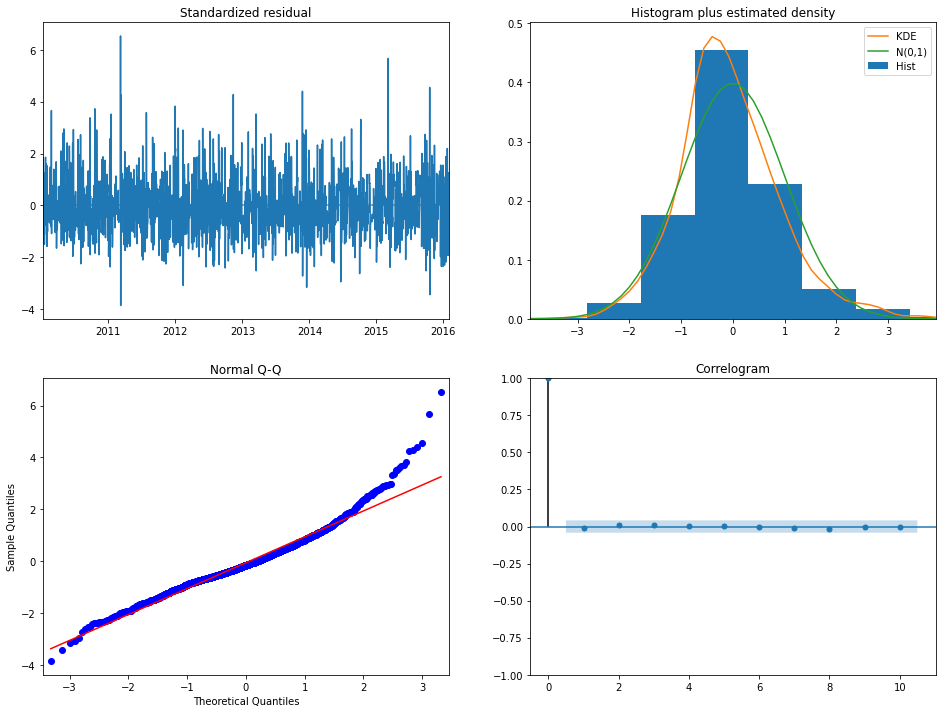

In [27]:
# residual diagnostics
res1.plot_diagnostics(figsize=(16, 12))
plt.close()

#### Comment:

In the upper left plot, the residual appears to be quite stationary. It has roughly constant mean (~0) and variance over time. The upper right plot shows the residual is close to normal distribution (Gaussian noise), which reinforces the previous statement. The normal Q-Q plot doesn't look too bad, and the series's autocorrelation with itself is consistently close to 0, both of which show that the residual is close to a normal distribution.

<br><br><br>
####  Forecast
To measure model performance and better visualize the forecast, the last 150 days instead of 1 day of data are forecasted.

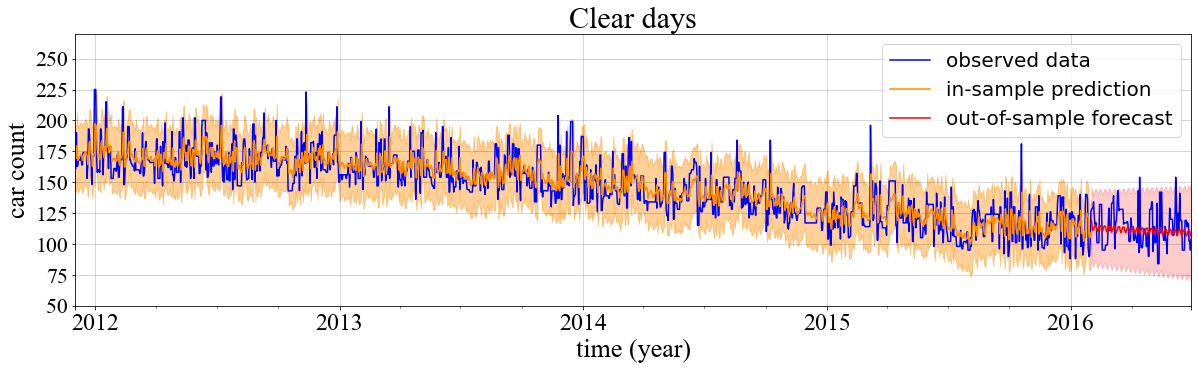

In [28]:
# in-sample prediction
pred = res1.get_prediction(start=700)
cf_pred = pred.conf_int() # 95% confidence interval 

# out-of-sample forecast (last 5 months)
fcast = res1.get_forecast(steps=150) 
cf_fcast = fcast.conf_int()# 95% confidence interval

# plot 
f = plt.figure(figsize=(20, 5))
p = clear1[700:].plot(label='observed data', color='blue')

# in-sample
p1 = pred.predicted_mean.plot(ax=p, 
                              label='in-sample prediction', 
                              color='darkorange')
q1 = p1.fill_between(cf_pred.index, 
                     cf_pred.iloc[:, 0], 
                     cf_pred.iloc[:, 1], 
                     color='darkorange', alpha=0.4)

# out-of-sample
p2 = fcast.predicted_mean.plot(ax=p1, 
                               label='out-of-sample forecast', 
                               color='red')
q2 = p1.fill_between(cf_fcast.index, 
                     cf_fcast.iloc[:, 0], 
                     cf_fcast.iloc[:, 1], 
                     color='red', alpha=0.2)

t = plt.title('Clear days', fontname="Times New Roman", fontsize=30)
x = plt.xlabel('time (year)', fontname="Times New Roman", fontsize=26)
y =  plt.ylabel('car count', fontname="Times New Roman", fontsize=26)
xi = plt.xticks(fontname="Times New Roman", fontsize=24)  
yi = plt.yticks(fontname="Times New Roman", fontsize=22) 
yl = plt.ylim(50, 270)
l = plt.legend(fontsize=20)
plt.grid(color='black', alpha=0.2)


plt.show()

####  Comment:
1. In-sample prediction works pretty well. To obtain the likely range of car counts, 95% confidence interval around the predicted mean is used. The interval does cover most of the observed data, except for a few of the tall peaks. <br><br>
2. Out-of-sample forecast work quite well too. Its 95% confidence interval covers most of the observed data except for one tallest peak. The forecasted confidence interval diverges into the future, which is expected. <br><br>

3. The model is not capable of catching most of the sharp peaks out-of-sample. Including holiday effects may help predict them more accurately.

## 2. Cloudy days

In [29]:
# split out training set
test_len = 150
train_len = cloudy1.shape[0] - test_len
train2 = cloudy1[:train_len]

In [30]:
# find the best SARIMA model with grid search (5 min run)

# set parameter range
p = range(0, 3)
d = range(1, 3)
q = range(1, 3)
P = range(0, 2)
D = range(0, 2)
Q = range(0, 2)
s = range(7, 8)

# create all parameter combinations
pdq = list(itertools.product(p, d, q))
pdq_season = list(itertools.product(P, D, Q, s))

# SARIMA
for param in pdq:
    for param_s in pdq_season:
            mod = SARIMAX(train2,
                          order=param,
                          seasonal_order=param_s)
            res = mod.fit()
            print('SARIMA{},{} - AIC:{}'.format(param, param_s, res.aic))
            res.summary().tables[1]

SARIMA(0, 1, 1),(0, 0, 0, 7) - AIC:22402.54488607554


,coef,std err,z,P>|z|,[0.025,0.975]
ma.L1,-0.4515,0.018,-24.992,0.000,-0.487,-0.416
sigma2,1403.7510,31.944,43.944,0.000,1341.141,1466.361


SARIMA(0, 1, 1),(0, 0, 1, 7) - AIC:22401.87498269389


,coef,std err,z,P>|z|,[0.025,0.975]
ma.L1,-0.4605,0.018,-25.506,0.000,-0.496,-0.425
ma.S.L7,-0.0347,0.020,-1.735,0.083,-0.074,0.004
sigma2,1402.0642,32.445,43.214,0.000,1338.473,1465.655


SARIMA(0, 1, 1),(0, 1, 0, 7) - AIC:23934.642260685447


,coef,std err,z,P>|z|,[0.025,0.975]
ma.L1,-0.3687,0.019,-19.324,0.000,-0.406,-0.331
sigma2,2895.2739,65.904,43.931,0.000,2766.104,3024.444


SARIMA(0, 1, 1),(0, 1, 1, 7) - AIC:22370.877378354962


,coef,std err,z,P>|z|,[0.025,0.975]
ma.L1,-0.4500,0.018,-24.843,0.000,-0.485,-0.414
ma.S.L7,-0.9999,0.251,-3.982,0.000,-1.492,-0.508
sigma2,1401.8165,349.252,4.014,0.000,717.295,2086.338


SARIMA(0, 1, 1),(1, 0, 0, 7) - AIC:22401.78974609071


,coef,std err,z,P>|z|,[0.025,0.975]
ma.L1,-0.4607,0.018,-25.530,0.000,-0.496,-0.425
ar.S.L7,-0.0358,0.020,-1.799,0.072,-0.075,0.003
sigma2,1401.9851,32.463,43.187,0.000,1338.359,1465.612


SARIMA(0, 1, 1),(1, 0, 1, 7) - AIC:22403.549139913648


,coef,std err,z,P>|z|,[0.025,0.975]
ma.L1,-0.4604,0.018,-25.538,0.000,-0.496,-0.425
ar.S.L7,-0.2201,0.523,-0.421,0.674,-1.245,0.805
ma.S.L7,0.1837,0.528,0.348,0.728,-0.851,1.218
sigma2,1400.5847,32.425,43.195,0.000,1337.034,1464.136


SARIMA(0, 1, 1),(1, 1, 0, 7) - AIC:23235.259926320265


,coef,std err,z,P>|z|,[0.025,0.975]
ma.L1,-0.4019,0.019,-21.638,0.000,-0.438,-0.366
ar.S.L7,-0.5215,0.015,-35.830,0.000,-0.550,-0.493
sigma2,2107.0645,50.116,42.044,0.000,2008.840,2205.289


SARIMA(0, 1, 1),(1, 1, 1, 7) - AIC:22369.9105517508


,coef,std err,z,P>|z|,[0.025,0.975]
ma.L1,-0.4594,0.018,-25.432,0.000,-0.495,-0.424
ar.S.L7,-0.0375,0.020,-1.884,0.060,-0.076,0.002
ma.S.L7,-0.9991,0.037,-26.900,0.000,-1.072,-0.926
sigma2,1400.5115,57.497,24.358,0.000,1287.820,1513.203


SARIMA(0, 1, 2),(0, 0, 0, 7) - AIC:22246.946941556667


,coef,std err,z,P>|z|,[0.025,0.975]
ma.L1,-0.4536,0.020,-22.144,0.000,-0.494,-0.413
ma.L2,-0.3140,0.019,-16.940,0.000,-0.350,-0.278
sigma2,1307.2505,38.506,33.949,0.000,1231.780,1382.721


SARIMA(0, 1, 2),(0, 0, 1, 7) - AIC:22243.95501623916


,coef,std err,z,P>|z|,[0.025,0.975]
ma.L1,-0.4545,0.021,-22.088,0.000,-0.495,-0.414
ma.L2,-0.3055,0.019,-16.342,0.000,-0.342,-0.269
ma.S.L7,-0.0479,0.020,-2.348,0.019,-0.088,-0.008
sigma2,1304.3306,38.457,33.916,0.000,1228.955,1379.706


SARIMA(0, 1, 2),(0, 1, 0, 7) - AIC:23667.25756707703


,coef,std err,z,P>|z|,[0.025,0.975]
ma.L1,-0.5464,0.181,-3.018,0.003,-0.901,-0.192
ma.L2,-0.4535,0.087,-5.233,0.000,-0.623,-0.284
sigma2,2555.5032,475.524,5.374,0.000,1623.494,3487.513


SARIMA(0, 1, 2),(0, 1, 1, 7) - AIC:22218.235963833806


,coef,std err,z,P>|z|,[0.025,0.975]
ma.L1,-0.4518,0.020,-22.054,0.000,-0.492,-0.412
ma.L2,-0.3116,0.019,-16.634,0.000,-0.348,-0.275
ma.S.L7,-0.9981,0.018,-54.588,0.000,-1.034,-0.962
sigma2,1308.3205,42.985,30.437,0.000,1224.072,1392.569


SARIMA(0, 1, 2),(1, 0, 0, 7) - AIC:22243.927746526682


,coef,std err,z,P>|z|,[0.025,0.975]
ma.L1,-0.4542,0.021,-22.068,0.000,-0.495,-0.414
ma.L2,-0.3052,0.019,-16.330,0.000,-0.342,-0.269
ar.S.L7,-0.0482,0.020,-2.379,0.017,-0.088,-0.008
sigma2,1304.3306,38.436,33.935,0.000,1228.997,1379.664


SARIMA(0, 1, 2),(1, 0, 1, 7) - AIC:22245.91562126836


,coef,std err,z,P>|z|,[0.025,0.975]
ma.L1,-0.4539,0.021,-21.934,0.000,-0.494,-0.413
ma.L2,-0.3051,0.019,-16.314,0.000,-0.342,-0.268
ar.S.L7,-0.1007,0.417,-0.242,0.809,-0.917,0.716
ma.S.L7,0.0527,0.420,0.125,0.900,-0.770,0.875
sigma2,1304.4172,38.445,33.929,0.000,1229.065,1379.769


SARIMA(0, 1, 2),(1, 1, 0, 7) - AIC:23064.61257389063


,coef,std err,z,P>|z|,[0.025,0.975]
ma.L1,-0.5325,0.110,-4.835,0.000,-0.748,-0.317
ma.L2,-0.4675,0.056,-8.378,0.000,-0.577,-0.358
ar.S.L7,-0.4893,0.018,-27.922,0.000,-0.524,-0.455
sigma2,1942.4620,227.791,8.527,0.000,1496.001,2388.923


SARIMA(0, 1, 2),(1, 1, 1, 7) - AIC:22214.76416624216


,coef,std err,z,P>|z|,[0.025,0.975]
ma.L1,-0.4526,0.021,-21.986,0.000,-0.493,-0.412
ma.L2,-0.3028,0.019,-16.042,0.000,-0.340,-0.266
ar.S.L7,-0.0497,0.020,-2.453,0.014,-0.089,-0.010
ma.S.L7,-0.9995,0.059,-16.897,0.000,-1.115,-0.884
sigma2,1303.4519,82.070,15.882,0.000,1142.598,1464.306


SARIMA(0, 2, 1),(0, 0, 0, 7) - AIC:22644.655736216046


,coef,std err,z,P>|z|,[0.025,0.975]
ma.L1,-0.9997,0.084,-11.948,0.000,-1.164,-0.836
sigma2,1567.2929,133.914,11.704,0.000,1304.827,1829.759


SARIMA(0, 2, 1),(0, 0, 1, 7) - AIC:22646.48140947263


,coef,std err,z,P>|z|,[0.025,0.975]
ma.L1,-1.0000,1.424,-0.702,0.483,-3.792,1.792
ma.S.L7,-0.0061,0.020,-0.296,0.767,-0.046,0.034
sigma2,1567.3477,2232.196,0.702,0.483,-2807.675,5942.371


SARIMA(0, 2, 1),(0, 1, 0, 7) - AIC:24127.709576131427


,coef,std err,z,P>|z|,[0.025,0.975]
ma.L1,-0.9995,0.057,-17.664,0.000,-1.110,-0.889
sigma2,3163.7178,188.703,16.766,0.000,2793.867,3533.569


SARIMA(0, 2, 1),(0, 1, 1, 7) - AIC:22620.936802759945


,coef,std err,z,P>|z|,[0.025,0.975]
ma.L1,-0.9992,0.099,-10.100,0.000,-1.193,-0.805
ma.S.L7,-0.9982,0.017,-57.368,0.000,-1.032,-0.964
sigma2,1565.5477,159.399,9.822,0.000,1253.131,1877.964


SARIMA(0, 2, 1),(1, 0, 0, 7) - AIC:22646.479535846076


,coef,std err,z,P>|z|,[0.025,0.975]
ma.L1,-0.9999,0.397,-2.519,0.012,-1.778,-0.222
ar.S.L7,-0.0064,0.020,-0.312,0.755,-0.046,0.034
sigma2,1567.1763,622.223,2.519,0.012,347.642,2786.710


SARIMA(0, 2, 1),(1, 0, 1, 7) - AIC:22648.23937600523


,coef,std err,z,P>|z|,[0.025,0.975]
ma.L1,-1.0000,1.330,-0.752,0.452,-3.607,1.607
ar.S.L7,-0.3311,1.481,-0.224,0.823,-3.233,2.571
ma.S.L7,0.3196,1.488,0.215,0.830,-2.596,3.235
sigma2,1567.1216,2083.717,0.752,0.452,-2516.889,5651.132


SARIMA(0, 2, 1),(1, 1, 0, 7) - AIC:23439.934462658886


,coef,std err,z,P>|z|,[0.025,0.975]
ma.L1,-1.0000,0.861,-1.162,0.245,-2.687,0.687
ar.S.L7,-0.5171,0.014,-35.911,0.000,-0.545,-0.489
sigma2,2313.3822,1989.229,1.163,0.245,-1585.434,6212.199


SARIMA(0, 2, 1),(1, 1, 1, 7) - AIC:22623.07114678423


,coef,std err,z,P>|z|,[0.025,0.975]
ma.L1,-0.9987,0.063,-15.735,0.000,-1.123,-0.874
ar.S.L7,-0.0080,0.020,-0.394,0.693,-0.048,0.032
ma.S.L7,-0.9996,0.082,-12.119,0.000,-1.161,-0.838
sigma2,1566.4988,164.141,9.544,0.000,1244.788,1888.210


SARIMA(0, 2, 2),(0, 0, 0, 7) - AIC:22404.360077758753


,coef,std err,z,P>|z|,[0.025,0.975]
ma.L1,-1.4499,0.322,-4.506,0.000,-2.081,-0.819
ma.L2,0.4499,0.144,3.128,0.002,0.168,0.732
sigma2,1404.4698,462.886,3.034,0.002,497.230,2311.710


SARIMA(0, 2, 2),(0, 0, 1, 7) - AIC:22403.793264585125


,coef,std err,z,P>|z|,[0.025,0.975]
ma.L1,-1.4587,0.354,-4.121,0.000,-2.152,-0.765
ma.L2,0.4587,0.161,2.843,0.004,0.143,0.775
ma.S.L7,-0.0340,0.020,-1.697,0.090,-0.073,0.005
sigma2,1402.6659,507.397,2.764,0.006,408.185,2397.146


SARIMA(0, 2, 2),(0, 1, 0, 7) - AIC:23935.438849182363


,coef,std err,z,P>|z|,[0.025,0.975]
ma.L1,-1.3677,0.659,-2.074,0.038,-2.660,-0.075
ma.L2,0.3677,0.239,1.538,0.124,-0.101,0.836
sigma2,2896.7320,1934.098,1.498,0.134,-894.030,6687.494


SARIMA(0, 2, 2),(0, 1, 1, 7) - AIC:22382.04433276735


,coef,std err,z,P>|z|,[0.025,0.975]
ma.L1,-1.4462,0.049,-29.531,0.000,-1.542,-1.350
ma.L2,0.4467,0.025,17.760,0.000,0.397,0.496
ma.S.L7,-0.9981,0.018,-55.155,0.000,-1.034,-0.963
sigma2,1405.1774,86.461,16.252,0.000,1235.716,1574.639


SARIMA(0, 2, 2),(1, 0, 0, 7) - AIC:22403.708104546116


,coef,std err,z,P>|z|,[0.025,0.975]
ma.L1,-1.4589,0.463,-3.154,0.002,-2.366,-0.552
ma.L2,0.4589,0.211,2.174,0.030,0.045,0.873
ar.S.L7,-0.0351,0.020,-1.760,0.078,-0.074,0.004
sigma2,1402.6810,659.694,2.126,0.033,109.704,2695.658


SARIMA(0, 2, 2),(1, 0, 1, 7) - AIC:22405.4544568195


,coef,std err,z,P>|z|,[0.025,0.975]
ma.L1,-1.4587,0.446,-3.272,0.001,-2.332,-0.585
ma.L2,0.4587,0.203,2.257,0.024,0.060,0.857
ar.S.L7,-0.2332,0.530,-0.440,0.660,-1.272,0.805
ma.S.L7,0.1975,0.535,0.369,0.712,-0.851,1.246
sigma2,1402.6832,636.138,2.205,0.027,155.876,2649.491


SARIMA(0, 2, 2),(1, 1, 0, 7) - AIC:23237.31390884318


,coef,std err,z,P>|z|,[0.025,0.975]
ma.L1,-1.4005,0.350,-3.996,0.000,-2.087,-0.714
ma.L2,0.4005,0.137,2.919,0.004,0.132,0.669
ar.S.L7,-0.5213,0.015,-35.557,0.000,-0.550,-0.493
sigma2,2107.8485,756.317,2.787,0.005,625.495,3590.202


SARIMA(0, 2, 2),(1, 1, 1, 7) - AIC:22382.194724741803


,coef,std err,z,P>|z|,[0.025,0.975]
ma.L1,-1.4523,0.028,-51.433,0.000,-1.508,-1.397
ma.L2,0.4535,0.019,23.602,0.000,0.416,0.491
ar.S.L7,-0.0363,0.020,-1.817,0.069,-0.075,0.003
ma.S.L7,-0.9986,0.023,-43.845,0.000,-1.043,-0.954
sigma2,1404.0661,62.424,22.492,0.000,1281.717,1526.415


SARIMA(1, 1, 1),(0, 0, 0, 7) - AIC:22121.1633651113


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.5616,0.021,27.153,0.000,0.521,0.602
ma.L1,-0.9908,0.003,-321.598,0.000,-0.997,-0.985
sigma2,1234.2093,40.161,30.732,0.000,1155.495,1312.923


SARIMA(1, 1, 1),(0, 0, 1, 7) - AIC:22122.64938596085


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.5610,0.021,27.125,0.000,0.520,0.602
ma.L1,-0.9911,0.003,-324.233,0.000,-0.997,-0.985
ma.S.L7,0.0149,0.021,0.726,0.468,-0.025,0.055
sigma2,1233.9164,40.184,30.707,0.000,1155.157,1312.676


SARIMA(1, 1, 1),(0, 1, 0, 7) - AIC:23536.228365771705


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.5241,0.018,28.679,0.000,0.488,0.560
ma.L1,-0.9999,0.077,-12.966,0.000,-1.151,-0.849
sigma2,2409.5117,198.285,12.152,0.000,2020.881,2798.143


SARIMA(1, 1, 1),(0, 1, 1, 7) - AIC:22096.75967155046


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.5608,0.021,27.102,0.000,0.520,0.601
ma.L1,-0.9895,0.004,-255.894,0.000,-0.997,-0.982
ma.S.L7,-0.9994,0.050,-20.043,0.000,-1.097,-0.902
sigma2,1233.4072,71.167,17.331,0.000,1093.922,1372.892


SARIMA(1, 1, 1),(1, 0, 0, 7) - AIC:22122.619199083718


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.5610,0.021,27.128,0.000,0.520,0.601
ma.L1,-0.9911,0.003,-324.532,0.000,-0.997,-0.985
ar.S.L7,0.0158,0.021,0.768,0.443,-0.025,0.056
sigma2,1233.8839,40.184,30.706,0.000,1155.125,1312.643


SARIMA(1, 1, 1),(1, 0, 1, 7) - AIC:22123.156042798495


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.5628,0.021,27.235,0.000,0.522,0.603
ma.L1,-0.9921,0.003,-330.720,0.000,-0.998,-0.986
ar.S.L7,0.7212,0.338,2.136,0.033,0.060,1.383
ma.S.L7,-0.6996,0.347,-2.017,0.044,-1.379,-0.020
sigma2,1233.0989,40.218,30.661,0.000,1154.273,1311.924


SARIMA(1, 1, 1),(1, 1, 0, 7) - AIC:22888.87418867552


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.5520,0.018,31.111,0.000,0.517,0.587
ma.L1,-1.0000,1.063,-0.941,0.347,-3.083,1.083
ar.S.L7,-0.5047,0.016,-31.935,0.000,-0.536,-0.474
sigma2,1794.3829,1912.070,0.938,0.348,-1953.205,5541.971


SARIMA(1, 1, 1),(1, 1, 1, 7) - AIC:22098.369725503893


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.5605,0.021,27.090,0.000,0.520,0.601
ma.L1,-0.9899,0.004,-259.186,0.000,-0.997,-0.982
ar.S.L7,0.0138,0.020,0.676,0.499,-0.026,0.054
ma.S.L7,-0.9988,0.025,-40.377,0.000,-1.047,-0.950
sigma2,1234.3433,48.588,25.404,0.000,1139.113,1329.574


SARIMA(1, 1, 2),(0, 0, 0, 7) - AIC:22119.24583191939


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.6178,0.030,20.392,0.000,0.558,0.677
ma.L1,-1.0721,0.034,-31.430,0.000,-1.139,-1.005
ma.L2,0.0795,0.033,2.387,0.017,0.014,0.145
sigma2,1232.0091,40.049,30.763,0.000,1153.515,1310.503


SARIMA(1, 1, 2),(0, 0, 1, 7) - AIC:22120.94039067647


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.6159,0.030,20.288,0.000,0.556,0.675
ma.L1,-1.0703,0.034,-31.391,0.000,-1.137,-1.003
ma.L2,0.0777,0.033,2.330,0.020,0.012,0.143
ma.S.L7,0.0115,0.021,0.563,0.574,-0.029,0.052
sigma2,1231.8498,40.075,30.739,0.000,1153.305,1310.395


SARIMA(1, 1, 2),(0, 1, 0, 7) - AIC:23538.005864252278


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.5100,0.033,15.241,0.000,0.444,0.576
ma.L1,-0.9807,0.331,-2.961,0.003,-1.630,-0.331
ma.L2,-0.0193,0.037,-0.517,0.605,-0.092,0.054
sigma2,2408.6759,783.147,3.076,0.002,873.737,3943.615


SARIMA(1, 1, 2),(0, 1, 1, 7) - AIC:22094.89231029091


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.6174,0.031,20.000,0.000,0.557,0.678
ma.L1,-1.0709,0.035,-30.437,0.000,-1.140,-1.002
ma.L2,0.0793,0.034,2.331,0.020,0.013,0.146
ma.S.L7,-0.9991,0.032,-31.362,0.000,-1.061,-0.937
sigma2,1231.8965,53.846,22.878,0.000,1126.360,1337.433


SARIMA(1, 1, 2),(1, 0, 0, 7) - AIC:22120.923001396026


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.6158,0.030,20.284,0.000,0.556,0.675
ma.L1,-1.0702,0.034,-31.389,0.000,-1.137,-1.003
ma.L2,0.0776,0.033,2.327,0.020,0.012,0.143
ar.S.L7,0.0122,0.021,0.595,0.552,-0.028,0.052
sigma2,1231.8389,40.075,30.738,0.000,1153.292,1310.385


SARIMA(1, 1, 2),(1, 0, 1, 7) - AIC:22121.45045572787


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.6172,0.030,20.447,0.000,0.558,0.676
ma.L1,-1.0708,0.034,-31.523,0.000,-1.137,-1.004
ma.L2,0.0775,0.033,2.327,0.020,0.012,0.143
ar.S.L7,0.7521,0.324,2.321,0.020,0.117,1.387
ma.S.L7,-0.7327,0.333,-2.199,0.028,-1.386,-0.080
sigma2,1230.8858,40.089,30.704,0.000,1152.313,1309.458


SARIMA(1, 1, 2),(1, 1, 0, 7) - AIC:22890.619511971363


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.5662,0.031,18.147,0.000,0.505,0.627
ma.L1,-1.0202,0.383,-2.663,0.008,-1.771,-0.269
ma.L2,0.0202,0.039,0.525,0.599,-0.055,0.096
ar.S.L7,-0.5051,0.016,-31.976,0.000,-0.536,-0.474
sigma2,1794.3247,683.834,2.624,0.009,454.034,3134.615


SARIMA(1, 1, 2),(1, 1, 1, 7) - AIC:22096.653458338267


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.6157,0.031,19.915,0.000,0.555,0.676
ma.L1,-1.0694,0.035,-30.404,0.000,-1.138,-1.000
ma.L2,0.0777,0.034,2.281,0.023,0.011,0.144
ar.S.L7,0.0103,0.020,0.506,0.613,-0.030,0.050
ma.S.L7,-0.9995,0.061,-16.389,0.000,-1.119,-0.880
sigma2,1231.3090,82.398,14.943,0.000,1069.811,1392.807


SARIMA(1, 2, 1),(0, 0, 0, 7) - AIC:22504.51617692714


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,-0.2489,0.020,-12.570,0.000,-0.288,-0.210
ma.L1,-1.0000,0.727,-1.376,0.169,-2.424,0.424
sigma2,1469.8855,1072.057,1.371,0.170,-631.307,3571.079


SARIMA(1, 2, 1),(0, 0, 1, 7) - AIC:22505.929746549074


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,-0.2496,0.020,-12.596,0.000,-0.288,-0.211
ma.L1,-1.0000,2.022,-0.495,0.621,-4.963,2.963
ma.S.L7,-0.0158,0.020,-0.790,0.429,-0.055,0.023
sigma2,1469.2656,2974.488,0.494,0.621,-4360.623,7299.154


SARIMA(1, 2, 1),(0, 1, 0, 7) - AIC:24008.935979553717


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,-0.2303,0.020,-11.234,0.000,-0.270,-0.190
ma.L1,-0.9999,0.186,-5.370,0.000,-1.365,-0.635
sigma2,2995.4789,563.942,5.312,0.000,1890.172,4100.786


SARIMA(1, 2, 1),(0, 1, 1, 7) - AIC:22480.981252276735


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,-0.2491,0.020,-12.388,0.000,-0.289,-0.210
ma.L1,-0.9998,0.395,-2.529,0.011,-1.775,-0.225
ma.S.L7,-0.9997,0.102,-9.784,0.000,-1.200,-0.799
sigma2,1468.7393,604.694,2.429,0.015,283.562,2653.917


SARIMA(1, 2, 1),(1, 0, 0, 7) - AIC:22505.91682493143


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,-0.2496,0.020,-12.590,0.000,-0.288,-0.211
ma.L1,-0.9999,0.174,-5.731,0.000,-1.342,-0.658
ar.S.L7,-0.0166,0.020,-0.829,0.407,-0.056,0.023
sigma2,1469.5289,261.455,5.621,0.000,957.087,1981.971


SARIMA(1, 2, 1),(1, 0, 1, 7) - AIC:22507.884408620575


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,-0.2495,0.020,-12.577,0.000,-0.288,-0.211
ma.L1,-0.9995,0.046,-21.672,0.000,-1.090,-0.909
ar.S.L7,-0.2772,0.948,-0.292,0.770,-2.136,1.582
ma.S.L7,0.2583,0.954,0.271,0.787,-1.612,2.128
sigma2,1468.6422,77.198,19.024,0.000,1317.337,1619.948


SARIMA(1, 2, 1),(1, 1, 0, 7) - AIC:23320.15885071805


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,-0.2316,0.021,-10.876,0.000,-0.273,-0.190
ma.L1,-1.0000,2.581,-0.388,0.698,-6.058,4.058
ar.S.L7,-0.5177,0.014,-35.918,0.000,-0.546,-0.489
sigma2,2188.8689,5649.923,0.387,0.698,-8884.777,1.33e+04


SARIMA(1, 2, 1),(1, 1, 1, 7) - AIC:22482.31020356541


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,-0.2498,0.020,-12.416,0.000,-0.289,-0.210
ma.L1,-0.9995,0.115,-8.729,0.000,-1.224,-0.775
ar.S.L7,-0.0185,0.020,-0.932,0.351,-0.058,0.020
ma.S.L7,-0.9997,0.104,-9.593,0.000,-1.204,-0.795
sigma2,1467.3608,231.026,6.351,0.000,1014.558,1920.164


SARIMA(1, 2, 2),(0, 0, 0, 7) - AIC:22157.638597743127


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.5599,0.022,25.963,0.000,0.518,0.602
ma.L1,-1.9795,0.004,-486.941,0.000,-1.987,-1.971
ma.L2,0.9799,0.004,241.018,0.000,0.972,0.988
sigma2,1254.5031,38.580,32.517,0.000,1178.889,1330.118


SARIMA(1, 2, 2),(0, 0, 1, 7) - AIC:22137.308790994306


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.5449,0.021,25.657,0.000,0.503,0.587
ma.L1,-1.9801,0.005,-380.333,0.000,-1.990,-1.970
ma.L2,0.9802,0.005,188.505,0.000,0.970,0.990
ma.S.L7,-0.0010,0.021,-0.048,0.962,-0.041,0.039
sigma2,1225.2830,38.956,31.453,0.000,1148.931,1301.635


SARIMA(1, 2, 2),(0, 1, 0, 7) - AIC:23545.997060384005


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.5267,0.018,29.111,0.000,0.491,0.562
ma.L1,-1.9988,0.011,-178.770,0.000,-2.021,-1.977
ma.L2,0.9989,0.011,89.309,0.000,0.977,1.021
sigma2,2414.3957,71.396,33.817,0.000,2274.462,2554.330


SARIMA(1, 2, 2),(0, 1, 1, 7) - AIC:22135.780775192703


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.5535,0.022,25.253,0.000,0.511,0.596
ma.L1,-1.9693,0.006,-326.824,0.000,-1.981,-1.957
ma.L2,0.9698,0.006,160.916,0.000,0.958,0.982
ma.S.L7,-0.9998,0.137,-7.307,0.000,-1.268,-0.732
sigma2,1269.7383,174.116,7.292,0.000,928.477,1610.999


SARIMA(1, 2, 2),(1, 0, 0, 7) - AIC:22148.012527701492


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.5736,0.021,27.810,0.000,0.533,0.614
ma.L1,-1.9907,0.002,-817.184,0.000,-1.995,-1.986
ma.L2,0.9909,0.002,407.180,0.000,0.986,0.996
ar.S.L7,0.0214,0.020,1.055,0.291,-0.018,0.061
sigma2,1224.7994,37.976,32.252,0.000,1150.368,1299.231


SARIMA(1, 2, 2),(1, 0, 1, 7) - AIC:22149.79542786228


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.5520,0.022,24.994,0.000,0.509,0.595
ma.L1,-1.9756,0.006,-346.300,0.000,-1.987,-1.964
ma.L2,0.9758,0.006,171.514,0.000,0.965,0.987
ar.S.L7,0.9298,1.638,0.568,0.570,-2.280,4.140
ma.S.L7,-0.9301,1.635,-0.569,0.569,-4.135,2.275
sigma2,1244.5408,39.125,31.810,0.000,1167.858,1321.224


SARIMA(1, 2, 2),(1, 1, 0, 7) - AIC:22916.858227826182


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.5665,0.017,32.585,0.000,0.532,0.601
ma.L1,-1.9993,0.056,-35.952,0.000,-2.108,-1.890
ma.L2,0.9999,0.056,17.974,0.000,0.891,1.109
ar.S.L7,-0.5018,0.016,-31.803,0.000,-0.533,-0.471
sigma2,1813.5002,113.163,16.026,0.000,1591.705,2035.296


SARIMA(1, 2, 2),(1, 1, 1, 7) - AIC:22155.071712274847


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.5461,0.023,24.154,0.000,0.502,0.590
ma.L1,-1.9522,0.008,-239.394,0.000,-1.968,-1.936
ma.L2,0.9532,0.008,116.289,0.000,0.937,0.969
ar.S.L7,0.0017,0.021,0.084,0.933,-0.039,0.042
ma.S.L7,-0.9996,0.081,-12.308,0.000,-1.159,-0.840
sigma2,1245.4923,104.292,11.942,0.000,1041.084,1449.901


SARIMA(2, 1, 1),(0, 0, 0, 7) - AIC:22119.74348888729


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.5407,0.023,23.995,0.000,0.496,0.585
ar.L2,0.0396,0.019,2.071,0.038,0.002,0.077
ma.L1,-0.9917,0.003,-334.885,0.000,-0.997,-0.986
sigma2,1232.2743,40.068,30.754,0.000,1153.742,1310.806


SARIMA(2, 1, 1),(0, 0, 1, 7) - AIC:22121.40949909842


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.5406,0.023,23.996,0.000,0.496,0.585
ar.L2,0.0387,0.019,2.023,0.043,0.001,0.076
ma.L1,-0.9918,0.003,-336.086,0.000,-0.998,-0.986
ma.S.L7,0.0121,0.021,0.588,0.556,-0.028,0.052
sigma2,1232.1100,40.095,30.730,0.000,1153.525,1310.695


SARIMA(2, 1, 1),(0, 1, 0, 7) - AIC:23538.019859016276


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.5290,0.021,25.394,0.000,0.488,0.570
ar.L2,-0.0095,0.020,-0.482,0.630,-0.048,0.029
ma.L1,-1.0000,0.308,-3.242,0.001,-1.604,-0.396
sigma2,2409.0942,746.377,3.228,0.001,946.223,3871.966


SARIMA(2, 1, 1),(0, 1, 1, 7) - AIC:22095.37094412874


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.5403,0.023,23.950,0.000,0.496,0.585
ar.L2,0.0396,0.020,2.027,0.043,0.001,0.078
ma.L1,-0.9906,0.004,-263.279,0.000,-0.998,-0.983
ma.S.L7,-0.9994,0.047,-21.203,0.000,-1.092,-0.907
sigma2,1231.7902,68.071,18.096,0.000,1098.374,1365.206


SARIMA(2, 1, 1),(1, 0, 0, 7) - AIC:22121.390431926484


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.5406,0.023,23.997,0.000,0.496,0.585
ar.L2,0.0386,0.019,2.020,0.043,0.001,0.076
ma.L1,-0.9919,0.003,-336.268,0.000,-0.998,-0.986
ar.S.L7,0.0128,0.021,0.621,0.534,-0.028,0.053
sigma2,1232.1016,40.096,30.729,0.000,1153.514,1310.689


SARIMA(2, 1, 1),(1, 0, 1, 7) - AIC:22121.92542995648


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.5422,0.023,24.009,0.000,0.498,0.586
ar.L2,0.0385,0.019,2.014,0.044,0.001,0.076
ma.L1,-0.9927,0.003,-341.241,0.000,-0.998,-0.987
ar.S.L7,0.7475,0.326,2.292,0.022,0.108,1.387
ma.S.L7,-0.7279,0.335,-2.171,0.030,-1.385,-0.071
sigma2,1231.2891,40.120,30.690,0.000,1152.655,1309.923


SARIMA(2, 1, 1),(1, 1, 0, 7) - AIC:22890.645319574927


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.5465,0.021,26.187,0.000,0.506,0.587
ar.L2,0.0103,0.020,0.501,0.617,-0.030,0.050
ma.L1,-1.0000,0.478,-2.092,0.036,-1.937,-0.063
ar.S.L7,-0.5051,0.016,-31.979,0.000,-0.536,-0.474
sigma2,1793.9501,863.351,2.078,0.038,101.814,3486.086


SARIMA(2, 1, 1),(1, 1, 1, 7) - AIC:22097.120328688656


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.5403,0.023,23.943,0.000,0.496,0.585
ar.L2,0.0387,0.020,1.985,0.047,0.000,0.077
ma.L1,-0.9908,0.004,-263.639,0.000,-0.998,-0.983
ar.S.L7,0.0108,0.020,0.532,0.595,-0.029,0.051
ma.S.L7,-0.9993,0.043,-23.292,0.000,-1.083,-0.915
sigma2,1231.8520,63.852,19.292,0.000,1106.703,1357.001


SARIMA(2, 1, 2),(0, 0, 0, 7) - AIC:22124.51390195088


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,-0.4043,0.083,-4.849,0.000,-0.568,-0.241
ar.L2,0.5394,0.053,10.196,0.000,0.436,0.643
ma.L1,-0.0223,0.078,-0.286,0.775,-0.175,0.130
ma.L2,-0.9595,0.077,-12.407,0.000,-1.111,-0.808
sigma2,1233.8504,40.152,30.730,0.000,1155.154,1312.547


SARIMA(2, 1, 2),(0, 0, 1, 7) - AIC:22126.184173920934


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,-0.4062,0.093,-4.356,0.000,-0.589,-0.223
ar.L2,0.5401,0.058,9.299,0.000,0.426,0.654
ma.L1,-0.0216,0.088,-0.245,0.806,-0.194,0.151
ma.L2,-0.9607,0.087,-11.000,0.000,-1.132,-0.790
ma.S.L7,0.0122,0.021,0.569,0.569,-0.030,0.054
sigma2,1233.6543,40.177,30.705,0.000,1154.909,1312.400


SARIMA(2, 1, 2),(0, 1, 0, 7) - AIC:23527.85348124311


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,-0.3943,0.048,-8.275,0.000,-0.488,-0.301
ar.L2,0.5045,0.026,19.343,0.000,0.453,0.556
ma.L1,-0.0932,0.286,-0.326,0.745,-0.654,0.468
ma.L2,-0.9068,0.256,-3.545,0.000,-1.408,-0.405
sigma2,2395.5647,673.843,3.555,0.000,1074.856,3716.273


SARIMA(2, 1, 2),(0, 1, 1, 7) - AIC:22122.793854775093


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,-0.4048,0.051,-7.955,0.000,-0.504,-0.305
ar.L2,0.5822,0.036,16.389,0.000,0.513,0.652
ma.L1,-0.0073,0.134,-0.055,0.956,-0.270,0.255
ma.L2,-0.9927,0.130,-7.635,0.000,-1.247,-0.738
ma.S.L7,-0.9988,0.028,-35.441,0.000,-1.054,-0.944
sigma2,1242.2070,145.771,8.522,0.000,956.500,1527.914


SARIMA(2, 1, 2),(1, 0, 0, 7) - AIC:22126.539270870475


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,-0.3259,0.731,-0.446,0.656,-1.759,1.107
ar.L2,0.4956,0.417,1.190,0.234,-0.321,1.312
ma.L1,-0.1026,0.727,-0.141,0.888,-1.527,1.322
ma.L2,-0.8806,0.720,-1.222,0.222,-2.292,0.531
ar.S.L7,0.0146,0.022,0.674,0.500,-0.028,0.057
sigma2,1233.8649,40.192,30.699,0.000,1155.089,1312.640


SARIMA(2, 1, 2),(1, 0, 1, 7) - AIC:22126.70235589787


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,-0.4051,0.096,-4.216,0.000,-0.593,-0.217
ar.L2,0.5424,0.060,9.074,0.000,0.425,0.660
ma.L1,-0.0220,0.091,-0.242,0.809,-0.200,0.156
ma.L2,-0.9622,0.090,-10.646,0.000,-1.139,-0.785
ar.S.L7,0.7319,0.347,2.109,0.035,0.052,1.412
ma.S.L7,-0.7116,0.357,-1.995,0.046,-1.411,-0.012
sigma2,1232.9870,40.219,30.657,0.000,1154.159,1311.815


SARIMA(2, 1, 2),(1, 1, 0, 7) - AIC:22889.26327580314


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,-0.4175,0.032,-13.211,0.000,-0.479,-0.356
ar.L2,0.5297,0.026,20.278,0.000,0.479,0.581
ma.L1,-0.0232,0.118,-0.196,0.845,-0.255,0.209
ma.L2,-0.9767,0.118,-8.288,0.000,-1.208,-0.746
ar.S.L7,-0.5133,0.017,-29.978,0.000,-0.547,-0.480
sigma2,1791.8227,220.198,8.137,0.000,1360.243,2223.403


SARIMA(2, 1, 2),(1, 1, 1, 7) - AIC:22123.398473419104


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,-0.4125,0.060,-6.850,0.000,-0.531,-0.294
ar.L2,0.5826,0.040,14.402,0.000,0.503,0.662
ma.L1,-0.0029,0.530,-0.006,0.996,-1.041,1.035
ma.L2,-0.9971,0.526,-1.897,0.058,-2.027,0.033
ar.S.L7,0.0262,0.021,1.254,0.210,-0.015,0.067
ma.S.L7,-0.9994,0.053,-18.880,0.000,-1.103,-0.896
sigma2,1244.0330,627.816,1.982,0.048,13.536,2474.530


SARIMA(2, 2, 1),(0, 0, 0, 7) - AIC:22417.23364641676


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,-0.2986,0.020,-15.293,0.000,-0.337,-0.260
ar.L2,-0.1985,0.021,-9.432,0.000,-0.240,-0.157
ma.L1,-1.0000,1.115,-0.896,0.370,-3.186,1.186
sigma2,1411.8673,1580.618,0.893,0.372,-1686.087,4509.822


SARIMA(2, 2, 1),(0, 0, 1, 7) - AIC:22418.945254558348


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,-0.2991,0.020,-15.311,0.000,-0.337,-0.261
ar.L2,-0.1983,0.021,-9.437,0.000,-0.239,-0.157
ma.L1,-0.9997,0.058,-17.385,0.000,-1.112,-0.887
ma.S.L7,-0.0127,0.020,-0.632,0.527,-0.052,0.027
sigma2,1411.3512,91.580,15.411,0.000,1231.858,1590.844


SARIMA(2, 2, 1),(0, 1, 0, 7) - AIC:23913.63003959222


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,-0.2782,0.020,-13.887,0.000,-0.317,-0.239
ar.L2,-0.2073,0.021,-9.695,0.000,-0.249,-0.165
ma.L1,-1.0000,0.722,-1.385,0.166,-2.415,0.415
sigma2,2865.9279,2074.614,1.381,0.167,-1200.241,6932.096


SARIMA(2, 2, 1),(0, 1, 1, 7) - AIC:22394.410485761706


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,-0.2985,0.020,-15.126,0.000,-0.337,-0.260
ar.L2,-0.1982,0.021,-9.327,0.000,-0.240,-0.157
ma.L1,-0.9996,0.146,-6.859,0.000,-1.285,-0.714
ma.S.L7,-0.9993,0.047,-21.196,0.000,-1.092,-0.907
sigma2,1410.8088,224.312,6.290,0.000,971.166,1850.452


SARIMA(2, 2, 1),(1, 0, 0, 7) - AIC:22418.94355882436


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,-0.2991,0.020,-15.314,0.000,-0.337,-0.261
ar.L2,-0.1983,0.021,-9.437,0.000,-0.239,-0.157
ma.L1,-0.9996,0.053,-18.754,0.000,-1.104,-0.895
ar.S.L7,-0.0132,0.020,-0.657,0.511,-0.052,0.026
sigma2,1411.2377,86.012,16.407,0.000,1242.656,1579.819


SARIMA(2, 2, 1),(1, 0, 1, 7) - AIC:22420.834024382177


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,-0.2991,0.020,-15.295,0.000,-0.337,-0.261
ar.L2,-0.1983,0.021,-9.395,0.000,-0.240,-0.157
ma.L1,-0.9995,0.037,-26.736,0.000,-1.073,-0.926
ar.S.L7,-0.3743,1.077,-0.347,0.728,-2.486,1.737
ma.S.L7,0.3587,1.085,0.331,0.741,-1.767,2.485
sigma2,1411.2130,65.616,21.507,0.000,1282.607,1539.819


SARIMA(2, 2, 1),(1, 1, 0, 7) - AIC:23228.905968643652


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,-0.2786,0.021,-13.542,0.000,-0.319,-0.238
ar.L2,-0.2032,0.022,-9.405,0.000,-0.246,-0.161
ma.L1,-0.9997,0.074,-13.490,0.000,-1.145,-0.854
ar.S.L7,-0.5164,0.015,-35.507,0.000,-0.545,-0.488
sigma2,2098.6679,165.455,12.684,0.000,1774.382,2422.954


SARIMA(2, 2, 1),(1, 1, 1, 7) - AIC:22395.881661441847


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,-0.2990,0.020,-15.122,0.000,-0.338,-0.260
ar.L2,-0.1979,0.021,-9.314,0.000,-0.240,-0.156
ma.L1,-0.9998,0.266,-3.753,0.000,-1.522,-0.478
ar.S.L7,-0.0151,0.020,-0.751,0.453,-0.054,0.024
ma.S.L7,-0.9999,0.212,-4.712,0.000,-1.416,-0.584
sigma2,1411.0058,492.940,2.862,0.004,444.861,2377.150


SARIMA(2, 2, 2),(0, 0, 0, 7) - AIC:22139.130834987882


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.5284,0.024,22.298,0.000,0.482,0.575
ar.L2,0.0325,0.020,1.606,0.108,-0.007,0.072
ma.L1,-1.9783,0.006,-340.882,0.000,-1.990,-1.967
ma.L2,0.9784,0.006,168.769,0.000,0.967,0.990
sigma2,1277.5383,42.034,30.393,0.000,1195.153,1359.924


SARIMA(2, 2, 2),(0, 0, 1, 7) - AIC:22139.499114748767


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.5471,0.023,23.736,0.000,0.502,0.592
ar.L2,0.0289,0.019,1.508,0.132,-0.009,0.067
ma.L1,-1.9828,0.005,-414.182,0.000,-1.992,-1.973
ma.L2,0.9830,0.005,205.452,0.000,0.974,0.992
ma.S.L7,-0.0079,0.020,-0.389,0.698,-0.048,0.032
sigma2,1223.4937,38.636,31.668,0.000,1147.769,1299.218


SARIMA(2, 2, 2),(0, 1, 0, 7) - AIC:23547.53274140034


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.5309,0.021,25.511,0.000,0.490,0.572
ar.L2,-0.0079,0.020,-0.405,0.686,-0.046,0.030
ma.L1,-1.9995,0.031,-64.118,0.000,-2.061,-1.938
ma.L2,0.9997,0.031,32.050,0.000,0.939,1.061
sigma2,2415.1591,98.795,24.446,0.000,2221.524,2608.794


SARIMA(2, 2, 2),(0, 1, 1, 7) - AIC:22442.33510619474


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,-0.4427,0.078,-5.673,0.000,-0.596,-0.290
ar.L2,-0.2763,0.023,-12.027,0.000,-0.321,-0.231
ma.L1,-0.7899,0.081,-9.736,0.000,-0.949,-0.631
ma.L2,-0.2067,0.084,-2.462,0.014,-0.371,-0.042
ma.S.L7,-0.9962,0.010,-102.604,0.000,-1.015,-0.977
sigma2,1482.9423,60.101,24.674,0.000,1365.146,1600.739


SARIMA(2, 2, 2),(1, 0, 0, 7) - AIC:22161.423458474845


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.5114,0.023,22.368,0.000,0.467,0.556
ar.L2,0.0358,0.020,1.791,0.073,-0.003,0.075
ma.L1,-1.9543,0.009,-206.440,0.000,-1.973,-1.936
ma.L2,0.9547,0.010,100.459,0.000,0.936,0.973
ar.S.L7,0.0124,0.021,0.606,0.544,-0.028,0.053
sigma2,1222.9758,37.925,32.248,0.000,1148.645,1297.307


LinAlgError: LU decomposition error.

In [31]:
# run best fit model

# parameters
order = (1, 1, 1)
seasonal_order = (0, 1, 1, 7)

# SARIMA
model = SARIMAX(train2, 
                order=order,
                seasonal_order=seasonal_order)

res2 = model.fit()
print('AIC score: %4.2f'% res2.aic)

AIC score: 22096.76


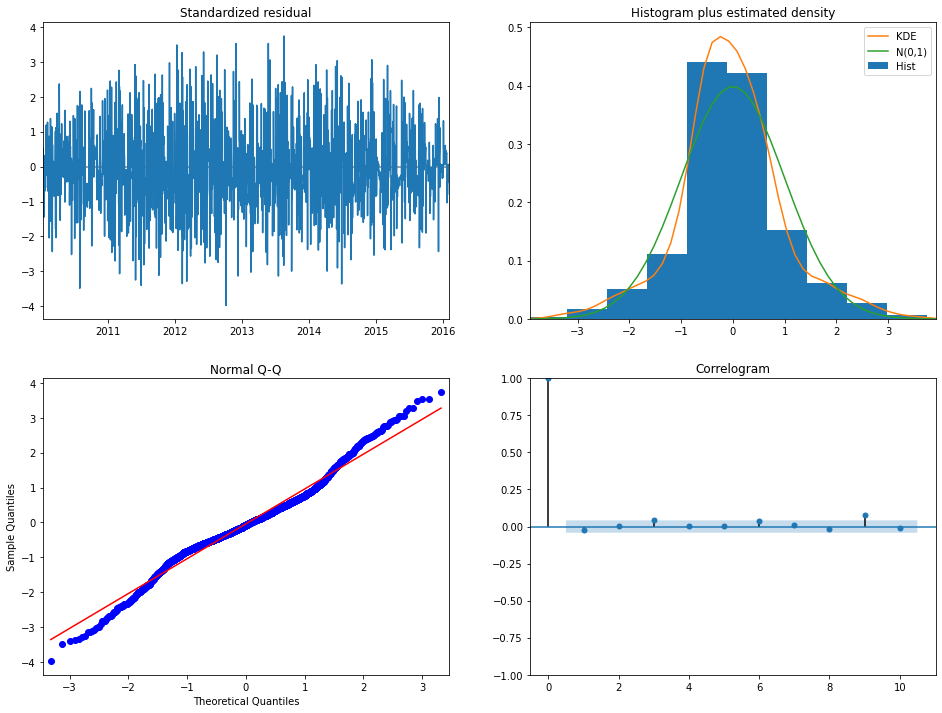

In [32]:
# residual diagnostics
res2.plot_diagnostics(figsize=(16, 12))
plt.close()

####  Comment:

The residual for cloudy day data is pretty stationary. It deviates a little from the normal distribution but is still a Gaussian distribution. 

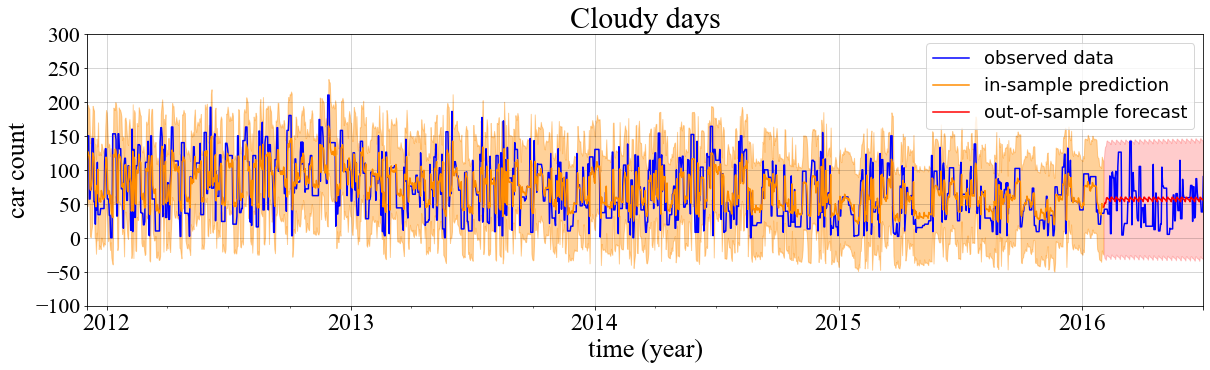

In [33]:
# in-sample prediction
pred = res2.get_prediction(start=700)
cf_pred = pred.conf_int() # 95% confidence interval 

# out-of-sample forecast (last 5 months)
fcast = res2.get_forecast(steps=150) 
cf_fcast = fcast.conf_int()# 95% confidence interval

# plot 
f = plt.figure(figsize=(20, 5))
p = cloudy1[700:].plot(label='observed data', color='blue')

# in-sample
p1 = pred.predicted_mean.plot(ax=p, 
                              label='in-sample prediction', 
                              color='darkorange')
q1 = p1.fill_between(cf_pred.index, 
                     cf_pred.iloc[:, 0], 
                     cf_pred.iloc[:, 1], 
                     color='darkorange', alpha=0.4)
# out-of-sample
p2 = fcast.predicted_mean.plot(ax=p1, 
                               label='out-of-sample forecast',
                               color='red')
q2 = p1.fill_between(cf_fcast.index, 
                     cf_fcast.iloc[:, 0], 
                     cf_fcast.iloc[:, 1], 
                     color='red', alpha=0.2)

t = plt.title('Cloudy days', fontname="Times New Roman", fontsize=30)
x = plt.xlabel('time (year)', fontname="Times New Roman", fontsize=26)
y =  plt.ylabel('car count', fontname="Times New Roman", fontsize=26)
xi = plt.xticks(fontname="Times New Roman", fontsize=24)  
yi = plt.yticks(fontname="Times New Roman", fontsize=22) 
l = plt.legend(fontsize=18)
yl = plt.ylim(-100, 300)
plt.grid(color='black', alpha=0.2)


plt.show()


####  Comment:
1. Cloudy day data is much more noisy, but the model still works pretty well. For in-sample prediction, the predicted 95% confidence interval covers most of the observed data. <br><br>
2. The out-of-sample forecast's 95% confidence interval also covers most of the observed data.
However, the forecast for cloudy days inevitably has a much wider confidence interval than clear days. Therefore, it's best to model clear days separately.<br><br>

# Concluding remarks

1. Car count forecasting using SARIMA works well for both clear days and cloudy days when they are modeled separately. This is a better approach than modeling both together, because cloudy days have higher noises due to varying cloud coverage. A separate model for cloudy days is helpful when it's inconclusive whether customer behavior changes with weather or cloud coverage. Otherwise, a model for clear days is sufficient. However, the time series for clear days is patchy and needs interpolation on missing data, which is not the most ideal situation. It is best to retrieve precise cloud coverage for cloudy days.<br><br>
2. This simple model only access performance on 1 holdout set. Building a walk forward model that evaluate performance on multiple holdout sets can be a safer approach.<br><br>
3. Seasonality is somewhat complex in the data. Its pattern also changes from time to time. Future works taking into account multiple seasonalities can help improve the model. It may also be beneficial to try a different time window for model training than using the full time series.<br><br>
4. There seems to be some holiday seasonalities in the data (ie. peaks in March/Octorber). Including the holiday effect may boost the accuracy of forecasting.<br><br>